In [1]:
import warnings 
warnings.simplefilter('ignore')
from prettytable import PrettyTable

In [2]:
from hidden_print import *
from feature_tools import *
from main_functions import *
from comment_analysis import *
from cleaning_utility import *
from prepare_clean_data import *
from stations_distances_utilities import*

# INTRODUCTION
To visualize our complete Airbnb dataset, we initially build a geographic map where all the cities and the associated total number of listings is shown. This is a rough representation, intended to introduce the completeness of the dataset in the representation of the international scenario!


In [3]:
data_location = '../data/DataSet/'
all_files = os.listdir(data_location)
listings_detailed = [i for i in all_files if 'listings_detailed.csv' in i]

# open all listings_detailed.csv files iteratively. For each file keep:
# the city and the average latitude, longitude
# the number of listings for each year year
# those info are stored in df_world

df_world = pd.DataFrame()

idx_advancment = 0
for file in listings_detailed:
    idx_advancment += 1
    city_name       = file.split('_')[1]
    print('> Analyzing city ' + str(int(idx_advancment)) + '/' + str(int(len(listings_detailed))) + ' : ' + city_name + '..................', end = '\r')
    tmp = pd.read_csv(data_location + '/' + file, low_memory = False)
    # drop useless columns
    tmp = tmp[['id', 'latitude', 'longitude']]
    # remove missing data
    tmp                    = tmp.dropna()
    # remove listings duplicates
    tmp                    = tmp.drop_duplicates('id')
    # geta average latitude and longitude for each city
    city_latitude          = tmp.latitude.mean()
    city_longitude         = tmp.longitude.mean()
    tmp['city_nb_listing'] = tmp.shape[0]
    tmp                    = tmp.drop(['id', 'latitude', 'longitude'], axis = 1)
    tmp                    = tmp.drop_duplicates()
    tmp['city_avg_latitude']  = city_latitude
    tmp['city_avg_longitude'] = city_longitude
    tmp['city'] = city_name
    df_world = pd.concat([df_world, tmp])
print('\n')

> Analyzing city 101/101 : Vancouver..............................



In [4]:
df_world.head(3)

city_nb_listing  city_avg_latitude  city_avg_longitude           city
0             8679          50.838026            4.362902       Brussels
0            36897          40.492010           17.650231         Puglia
0            48377          40.728818          -73.951264  New York City

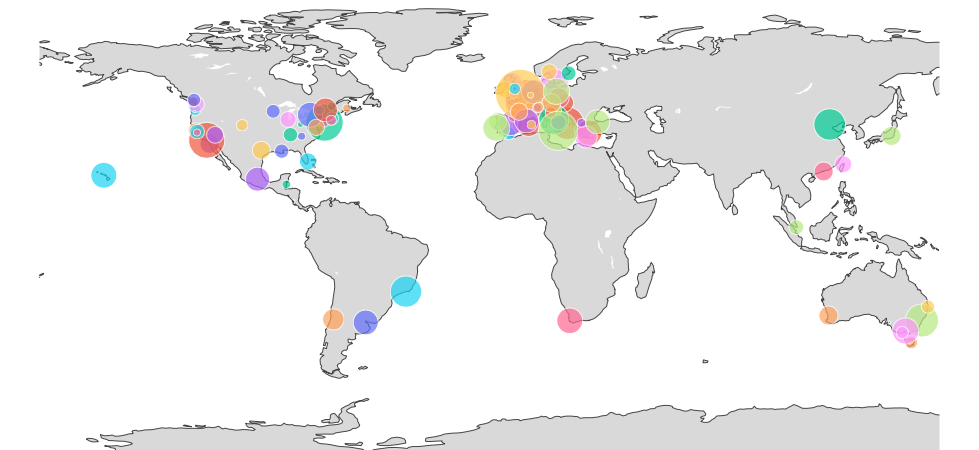

In [8]:
fig_saving_folder       = '../data/all_cities_analysis'


fig = px.scatter_geo(df_world, lat = 'city_avg_latitude', lon = 'city_avg_longitude', color = 'city',
                     hover_name = 'city', size = 'city_nb_listing', size_max = 35,
                     labels = {'city_nb_listing':'city nb. listings ', 'city_avg_latitude':'city latitude ',
                             'city_avg_longitude':'city longitude ', 'city':'city '})
fig.update_layout(showlegend=False, mapbox_style = 'open-street-map', geo = dict(scope = 'world',
                  landcolor = 'rgb(217, 217, 217)', showframe = False), 
                  margin = go.layout.Margin(l = 0, r = 0, b = 0, t = 0, pad=0), autosize = True)
# save figure 
html_map = pyplot(fig, filename = fig_saving_folder + '/Airbnb_world_map.html', auto_open = False)

fig.show()

# EXPLORING THE DATA AND DEFINING SUCCESS METRICS

The end goal of this project is to investigate what makes an Airbnb listing successful. In order to do so, we must ask ourselves the following questions:
- How can we define the "success" of a listing ?
- What parameters (neighbourhood/price/amenities/...) influence most the "success" of a listing ?
- Are the same parameters important for all cities ? 

In a first phase, we investigate whether the InsideAirBnb dataset can be used to answer our questions. For computation purposes, we first look into all of the listings of a single city: Amsterdam, as this city is a popular tourist destination and its dataset is not too large. 

For this part of the project, we use data from the following files:
- `2019-09-14_Amsterdam_listings_detailed.csv`
- `2019-09-14_Amsterdam_reviews.csv`

Before proceding to the investigation, three preliminary steps are necessary: 
- evaluating the quality of the data
- defining measures of success
- analyzing the data for the defined metrics




## DATA EXPLORATION 

Before attempting to find an answer to our research question, the usability of the data must be evaluated. In particular, we need to identify what kind of information our data contains. 

In [3]:
#load listing and review data

# paths Giacomo
#df_listings = pd.read_csv('/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_listings_detailed.csv', header=0, low_memory = False)
#df_comments = pd.read_csv('/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_reviews.csv', header=0)

# paths Pauline
df_listings = pd.read_csv('../data/2019-09-14_Amsterdam_listings_detailed.csv', header=0)
df_comments = pd.read_csv('../data/2019-09-14_Amsterdam_reviews.csv', header=0)

In order to analyze the data contained in the '...listings_detailed.csv' file, we proceed in answering the following questions:

    1. How many listings are there in this city ? Are they all unique ?
    2. What information can we get for a particular listing ?
    3. Are there missing values ? Do they make us lose valuable information ?
    4. Can the data be used as such or should it be transformed ?


In [4]:
df_listings.head()

id                         listing_url       scrape_id last_scraped  \
0   2818   https://www.airbnb.com/rooms/2818  20190914033014   2019-09-14   
1  20168  https://www.airbnb.com/rooms/20168  20190914033014   2019-09-14   
2  25428  https://www.airbnb.com/rooms/25428  20190914033014   2019-09-14   
3  27886  https://www.airbnb.com/rooms/27886  20190914033014   2019-09-14   
4  28871  https://www.airbnb.com/rooms/28871  20190914033014   2019-09-14   

                                                name  \
0           Quiet Garden View Room & Super Fast WiFi   
1       Studio with private bathroom in the centre 1   
2    Lovely apt in City Centre (w.lift) near Jordaan   
3  Romantic, stylish B&B houseboat in canal district   
4                            Comfortable double room   

                                             summary  \
0           Quiet Garden View Room & Super Fast WiFi   
1  Cozy studio on your own private floor, 100% in...   
2                                                NaN   
3  Stylish and romantic houseboat on fantastic hi...   
4                                                NaN   

                                               space  \
0  I'm renting a bedroom (room overlooking the ga...   
1  For those who like all facets of city life. In...   
2  This nicely furnished, newly renovated apt  is...   
3  For a romantic couple: A beautifully restored ...   
4  In a monumental house right in the center of A...   

                                         description experiences_offered  \
0  Quiet Garden View Room & Super Fast WiFi I'm r...                none   
1  Cozy studio on your own private floor, 100% in...                none   
2  This nicely furnished, newly renovated apt  is...                none   
3  Stylish and romantic houseboat on fantastic hi...                none   
4  In a monumental house right in the center of A...                none   

                               neighborhood_overview        ...          \
0  Indische Buurt ("Indies Neighborhood") is a ne...        ...           
1  Located just in between famous central canals....        ...           
2                                                NaN        ...           
3         Central, quiet, safe, clean and beautiful.        ...           
4                                                NaN        ...           

  instant_bookable is_business_travel_ready          cancellation_policy  \
0                t                        f  strict_14_with_grace_period   
1                f                        f  strict_14_with_grace_period   
2                f                        f  strict_14_with_grace_period   
3                t                        f  strict_14_with_grace_period   
4                f                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               2   
2                               2   
3                               1   
4                               3   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            0   
2                                            2   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            2   
2                                            0   
3                                 

In [5]:
# check proportion of missing features
total_cell_nbr = df_listings.shape[0]*df_listings.shape[1]
percentage_missing = df_listings.isna().sum().sum()/total_cell_nbr*100
print('Fraction of missing values in the dataframe: '+ str(round(percentage_missing,3))+'%')
print('')
print('The eight columns with the most missing data are (with % Nan in column): ')
display(df_listings.isna().sum().divide(df_listings.shape[0]/100).nlargest(8).round(2))
print('')
frac_in_5 = df_listings.isna().sum().nlargest(8).sum()/df_listings.isna().sum().sum()
print('Together, they account for: '+ str(round(frac_in_5*100,2)) +'% of the missing data.')
print('')

# check if listing ids are duplicated 
print('There are: ' + str(df_listings.duplicated('id', keep = False).sum()) + ' duplicated listing ids')

# check if listing ids are Nan or empty values
print('There are : ' + str(df_listings['id'].isna().sum()) + ' Nan values under id')
print('There are : ' + str(df_listings.id.loc[df_listings['id'].isnull()].sum()) + ' empty values under id')

Fraction of missing values in the dataframe: 13.997%

The eight columns with the most missing data are (with % Nan in column): 


thumbnail_url                   100.00
medium_url                      100.00
xl_picture_url                  100.00
host_acceptance_rate            100.00
neighbourhood_group_cleansed    100.00
license                          99.84
square_feet                      98.17
monthly_price                    93.40
dtype: float64


Together, they account for: 53.34% of the missing data.

There are: 0 duplicated listing ids
There are : 0 Nan values under id
There are : 0 empty values under id


To answer the questions stated above, we can observe the following:

- There are 106 columns in this dataset, one of which is the listing id, the others all contain different types of information about the listings.
- Each row of the dataset corresponds to a different listing.
- There are no missing listing ids.
- More than half of the missing data comes from eight columns, that are for the most part not essential parameters. 
- The neighbourhood information can be obtained from an other column: 'neibourhood_cleansed'.
- The 'square_feet' column, however could have been an intersting parameter.
- Some columns contain string type data, others contain numerical values.

From this analysis, we infer that the data is of sufficient quality to build success metrics and features of listing information that impact these success metrics. We can thus proceed to the next step: defining success metrics. 




### SUCCESS METRICS

To obtain accurate representations of how successful an AirBnb listing is, we go over the different kinds of information provided by the dataset containing the details of listing and identify the best success metrics. We also look into the other files provided by the Inside Airbnb dataset to construct other metrics.

#### 1. METRIC SELECTION

In [6]:
# glimpse at the info contained in the listing dataframe
cols_names = df_listings.columns.tolist()

# nice print
nb_per_row = 2
t = PrettyTable(['Features Names', 'Features Names (cont.)'])
for i in range(0, int(np.ceil(len(cols_names)/nb_per_row))):
    if len(cols_names[2*i:nb_per_row*i+nb_per_row]) == nb_per_row:
        t.add_row(cols_names[nb_per_row*i:nb_per_row*i+nb_per_row])
    else:
        new_row = cols_names[nb_per_row*i:nb_per_row*i+nb_per_row]
        new_row = new_row + ['-']*(nb_per_row-len(new_row))
        t.add_row(new_row)
print(t)

+---------------------------------------------+----------------------------------------------+
|                Features Names               |            Features Names (cont.)            |
+---------------------------------------------+----------------------------------------------+
|                      id                     |                 listing_url                  |
|                  scrape_id                  |                 last_scraped                 |
|                     name                    |                   summary                    |
|                    space                    |                 description                  |
|             experiences_offered             |            neighborhood_overview             |
|                    notes                    |                   transit                    |
|                    access                   |                 interaction                  |
|                 house_rules                 |   

By taking a look at the columns of this dataframe printed in the table above, it appears that some columns would intuitively be more suited than others to be chosen as success metrics.

These columns are:
- 'review_scores_rating'
- 'review_scores_accuracy'
- 'review_scores_cleanliness'
- 'review_scores_checkin'
- 'review_scores_communication'
- 'review_scores_location'
- 'review_scores_value'
- 'reviews_per_month'

Apart from the 'reviews_per_month' column, these columns are all averages of scores given to a listing by guests. These scores give some insight into the rating of a listing.

An other aspect we want to include as metric is the frequency at which a listing booked. To do so, we identified a column potentially suited to measure the booking frequency: 'reviews_per_month'. The values in this column average the number of reviews per month for a particular listing. It should be noted that not all guests leave reviews and that guests book a stay for different amounts of time. This value is thus not an exact measure of the number of nights booked per month, but rather an approximative indicator of the demand for a listing.

As it turns out, the 'review_scores_rating' values are calculated as weighted sum of the other 'review_scores_...'.
We can thus consider that all the other scores are taken into account in this one, such that it is necessary only for this metric to be kept.

Therefore, the remaining columns of interest are:
- 'review_scores_rating'
- 'reviews_per_month'

Alternatively, we could keep all the 'review_scores_...' columns and drop 'review_scores_rating', if we want to investigate specific aspects, such as cleanliness, communication, location...


#### 2. METRIC CONSTRUCTION

An other quantity can be used as a measure of a listing's succes: the sentiment of the comments left by the reviewers. Comments for all the listings of a given city can be found in a '...reviews.csv' file. From this file, the comments were processed and a sentiment analysis was performed (refer to the [commentsAnalysis.ipynb](https://github.com/vonalven/airbnb_ada_project/blob/master/notebooks/commentsAnalysis.ipynb) notebook for a complete exploration and step-by-step analysis of the reviews data). In doing so, we were able to extract a measure of sentiment: the Compound score. This is a metric with normalized values: the compound values range from -1 (most negative value) to 1 (most positive value).

In [ ]:
# add comment sentiment metric

# analyze comment data for each listing
#_, _, comments_en_copy = analyze_comments(df_comments) #this step is very long!
#df_comments_sentiment = comments_en_copy.copy()

# as the previous step takes some time to run, the result is saved and can be loaded for further use
#df_comments_sentiment.to_pickle("./df_comments_sentiment_final.pkl")

# uncomment to load stored comment analysis data 

# path Pauline
df_comments_sentiment = pd.read_pickle("../data/df_comments_sentiment_final.pkl")

In [8]:
df_comments_sentiment.to_csv("../data/df_comments_sentiment_final.csv")

In [8]:
df_comments_sentiment = pd.read_csv("../data/df_comments_sentiment_final.csv")

In [9]:
# drop 'neutrality', 'negativity' and 'positivity' columns as the one of interest is compound
df_comments_sentiment.drop(columns = ['neutrality', 'positivity', 'negativity'], inplace = True)
df_comments_sentiment.head()

listing_id  compound
0        2818  0.486691
1       20168  0.448888
2       25428  0.464547
3       27886  0.540527
4       28871  0.538121

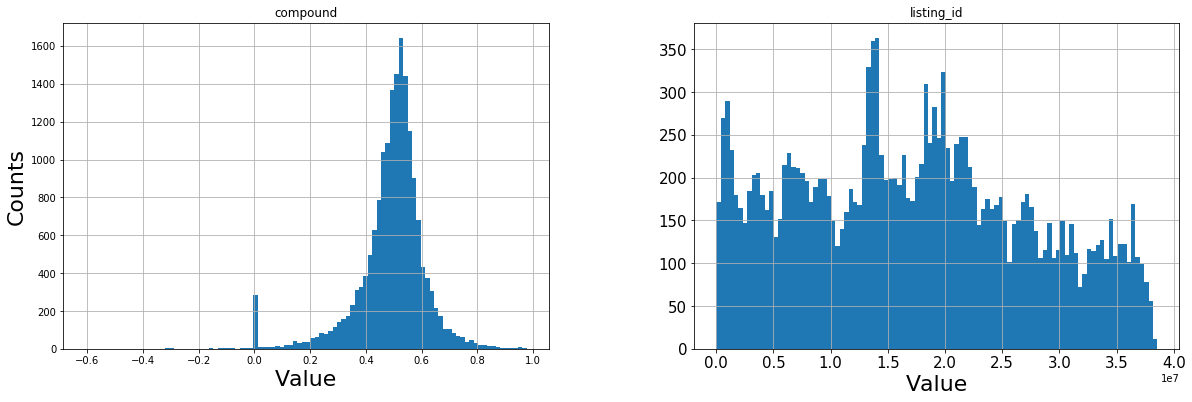

In [10]:
axes = df_comments_sentiment.hist(bins=100)
axes[0][0].set_xlabel('Value', fontsize = 22)
axes[0][1].set_xlabel('Value', fontsize = 22)
axes[0][0].set_ylabel('Counts', fontsize = 22)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.tick_params(labelsize = 15)
plt.show()

From the sentiment analysis, we only keep the compound of the overall comments for each listing.
Success can thus be defined by the 4 following metrics:

- 'review_scores_rating'
- 'reviews_per_month'
- 'compound'

The remaining columns (not used as metrics) will be further inspected in order to pre-select features.

In [11]:
print(df_listings.id.nunique())
print(df_comments_sentiment.listing_id.nunique())
print('%.2f%% of the hosts have no comment'%(((df_listings.id.nunique()- df_comments_sentiment.listing_id.nunique())/df_listings.id.nunique())*100))


20244
17591
13.11% of the hosts have no comment


We observe that only the 86.89% of the hosts have a comment. For the others, NaNs are present. This is not really a problem since in the data cleaning part we will handle NaNs (removed).

In [12]:
# create a new dataframe for success metrics
df_success_metrics = pd.merge(df_listings[['id', 'review_scores_rating', 'reviews_per_month']],
                              df_comments_sentiment, left_on='id', right_on='listing_id')
# change index to id
df_success_metrics = df_success_metrics.set_index('id').drop('listing_id', axis = 1)

df_success_metrics.head()

review_scores_rating  reviews_per_month  compound
id                                                      
2818                   98.0               2.11  0.486691
20168                  88.0               2.48  0.448888
25428                 100.0               0.15  0.464547
27886                  99.0               2.14  0.540527
28871                  97.0               2.67  0.538121

Compound values can be interpreted as follows:
- positive sentences if compound >= 0.05
- negative sentences if compound <= -0.05
- neutral sentences if compound < 0.05


#### 3. METRIC ANALYSIS

We now look more in depth into our chosen metrics. We first need to establish what kind of data we are working with and its usability. Moreover, we visualize the how the data for each metric is distributed and whether there are correlations between the metrics. 

In [13]:
c = (df_success_metrics == '').sum(axis=0)
for col in df_success_metrics:
    print('The metric '+ col + ':')
    # check range
    print('- is in the range: ['+ str(df_success_metrics[col].min())+', '+str(df_success_metrics[col].max())+']')
    # check for Nan values
    print('- has : ' + str(df_success_metrics[col].isna().sum()) + ' Nan values')
    # check for empty values
    print('- has : ' + str(c[col]) + ' empty values')
    print('')

The metric review_scores_rating:
- is in the range: [20.0, 100.0]
- has : 224 Nan values
- has : 0 empty values

The metric reviews_per_month:
- is in the range: [0.01, 52.24]
- has : 0 Nan values
- has : 0 empty values

The metric compound:
- is in the range: [-0.6059, 0.9766]
- has : 0 Nan values
- has : 0 empty values



Our metrics are all continuous numerical values that vary in a certain range. We observe that our data only contains missing values for a single metric: 'review_scores_rating'. The corresponding rows are to be dropped, as, even though there might be interesting information for the other parameters of these listings, without the associated metric, we cannot evaluate all the aspects of their "success".

In [14]:
# drop rows with Nan values
df_success_metrics.dropna(axis = 0, inplace = True)

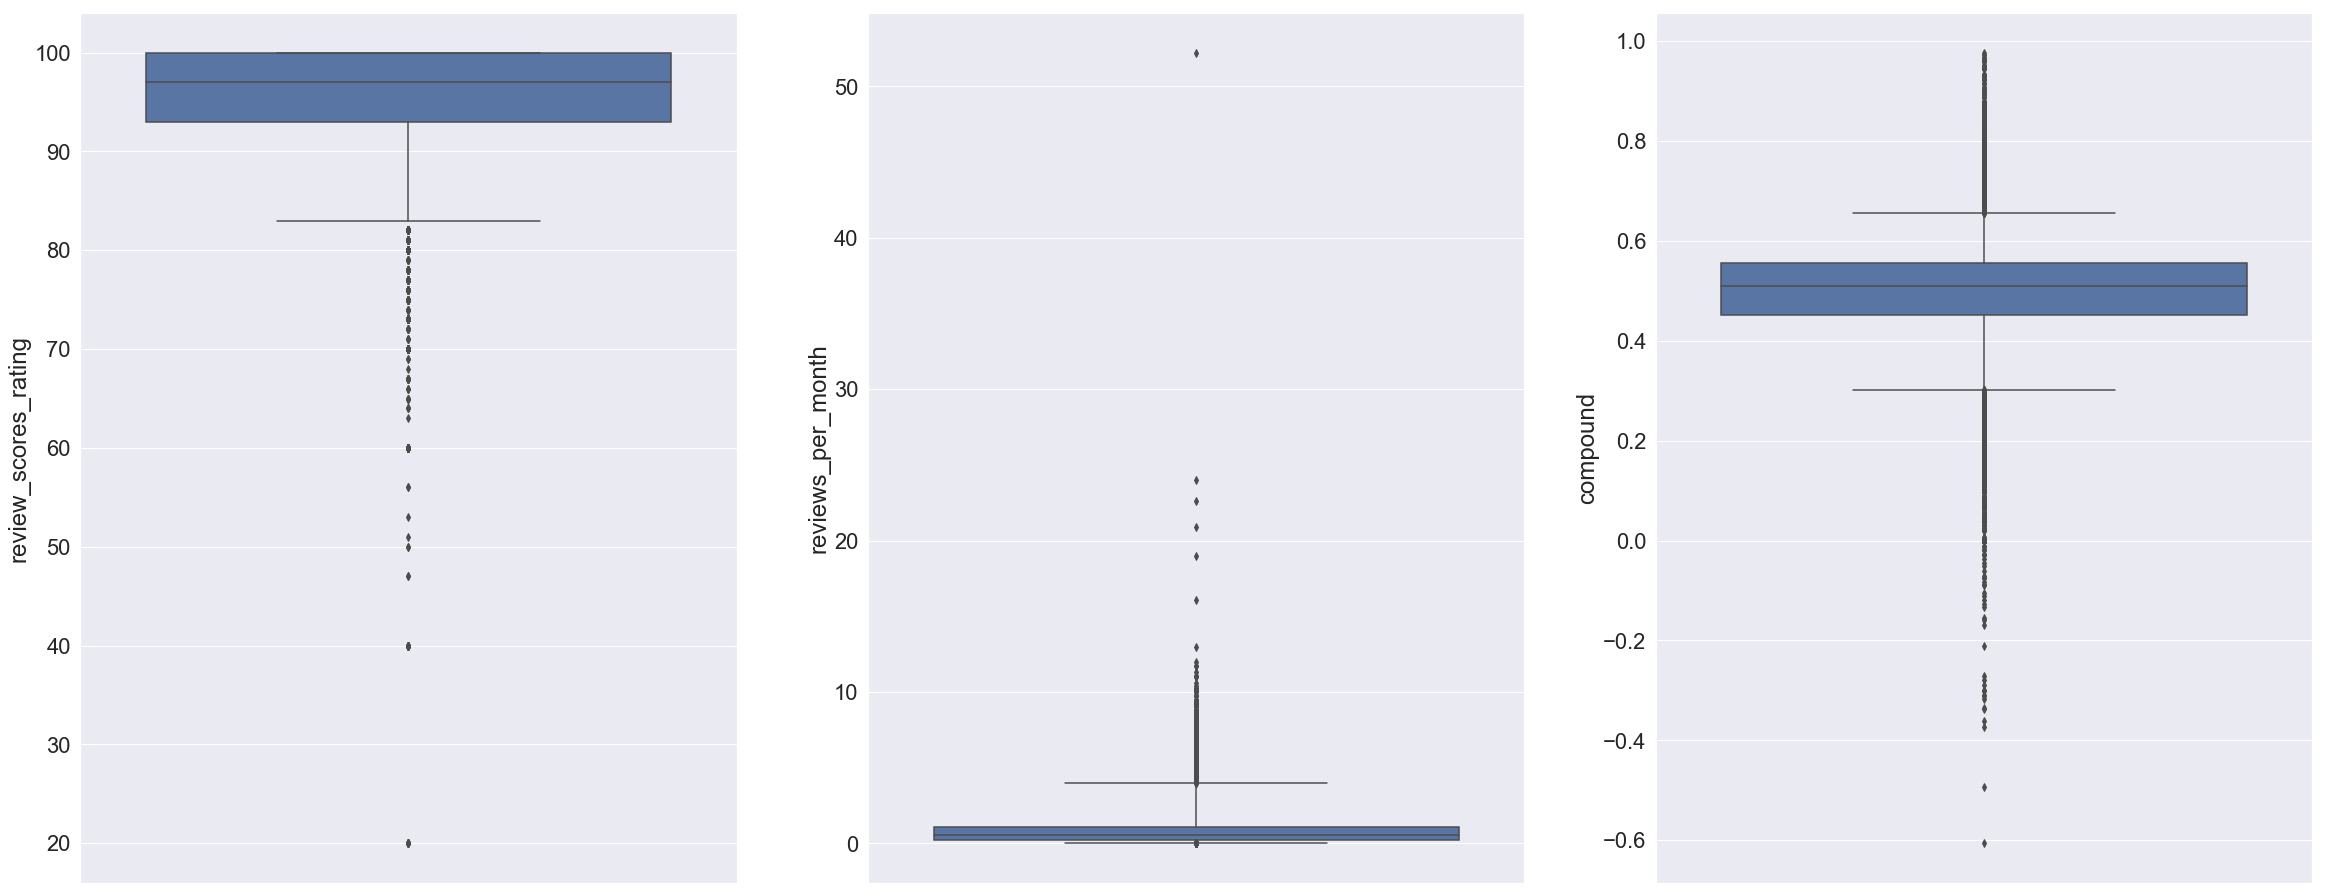

In [15]:
# create boxplots of the metrics
fig = plt.figure(figsize=(40, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
sns.set(font_scale = 2)

ax1 = plt.subplot(1, 3, 1)
ax1 = sns.boxplot(y=df_success_metrics['review_scores_rating'], whis=[5, 95])

ax2 = plt.subplot(1, 3, 2)
ax2 = sns.boxplot(y=df_success_metrics['reviews_per_month'], whis=[5, 95])

ax3 = plt.subplot(1, 3, 3)
ax3 = sns.boxplot(y=df_success_metrics['compound'], whis=[5, 95])

From looking at the boxplot of the listing data for the metric 'review_scores_rating', we observe that more than 95% of the listings have overall scores above 80/100. This means that in general, people tend to leave good scores and that only a small minority of listings are badly rated. This phenomenon could be due to AirBnb setting requirements for the hosts to meet.

By observing the second boxplot, we see that more than 95% of the listings get less than 5 reviews per month. We also notice an obvious outlier at more than 50 reviews per month. Unless this listing always gets reviewed by multiple individuals in groups, this value is very unlikely. This listing should therefore be removed.

The compound measuring the sentiment of guests seems to be mostly between 0.4 and 0.6, with few listings under outside this range. A gaussian distribution can be expected for this metric.

In [16]:
# remove obvious outliers (more than 30 reviews per months)
df_success_metrics.drop(df_success_metrics[df_success_metrics.reviews_per_month > 30].index, inplace=True)

# save final success metrics dataframe
df_success_metrics.to_pickle("./df_success_metrics_final.pkl")

In [17]:
df_success_metrics.to_csv("./df_success_metrics_final.csv")

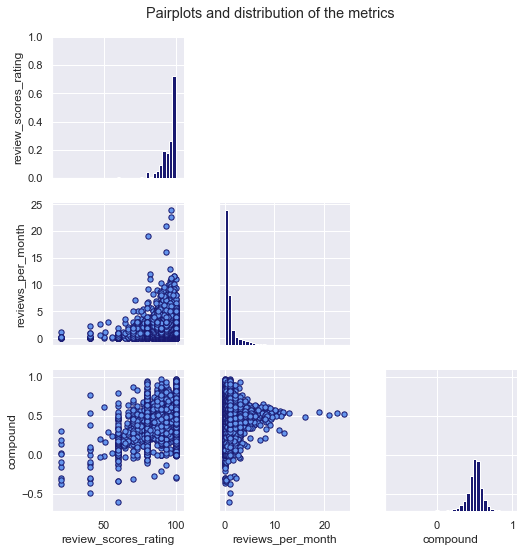

In [18]:
# plot the distribution and visualize correlation
sns.set(font_scale = 1)

# create pair grid
grid = sns.PairGrid(df_success_metrics)
grid.fig.tight_layout()
grid.fig.suptitle('Pairplots and distribution of the metrics', y=1.02)

# map plots to locations
grid = grid.map_lower(plt.scatter, edgecolor="midnightblue", s=28, color="cornflowerblue")
grid = grid.map_diag(plt.hist, bins=35, color="midnightblue")

# mask top right
for i, j in zip(*np.triu_indices_from(grid.axes, 1)):
    grid.axes[i, j].set_visible(False)

From the distribution plots of the metrics, we observe the following:
- `review_scores_rating` : distribution seems left-skewed, as stated previously, very few listing have overall scores under 80/100.
- `reviews_per_month` : distribution seems right-skewed, most listings get very few reviews per month.
- `compound` : gaussian distribution.

Plotting the metrics by pairs is a way of identifying visually whether two metrics are correlated. After a first glance, we notice that no pairs of metrics are clearly linearly correlated. However, we can identify a few trends:
- a positive sentiment (high compound) in the comments seems to be correlated with a high score, but the negative sentiments (low compound) do not show an obvious correlation to the score. 
- listings with more reviews per month have higher overall scores.

Given that we cannot identify a clear correlation pattern between pairs of metrics, we do not exclude any of them from the metric selection.

# COMPUTATION OF DISTANCES TO NEAREST STATION AND INTEGRATION TO `df_listings`

To compute geodesic distances several methods are available. Here we test the following:
- geopy.distance.geodesic: more precise, this takes into account the ellipsoid shape of the Earth
- haversine formula: it computes the distance of an arc on a sphere. This is less precise but for short distances, the error is low. Because of vectorial implementation, it is much faster! Since the distances are computed between stations and listings in the same city, the distance between them is not very large and the error should be low. Moreover, we are not interested in absolute precision; if the error is constant for one city (and it is the case because the 'ellipsoid' curvature on the city area is the same) it doesn't matter.

Those 2 approaches are tested and compared with the following code:

In [19]:
import time

df_listings = pd.read_csv('../data/2019-09-14_Amsterdam_listings_detailed.csv', header=0)
df_station           = geojson_to_dataframe('../data/Transports/amsterdam_stations.geojson')    
stations_coord       = get_station_coord(df_station)
listings_coord       = get_listing_coord(df_listings)
listings_coord       = listings_coord[0:1000]

dist_geodesic  = geodesic_distance(listings_coord[0], stations_coord)
dist_haversine = haversine_distance(listings_coord[0], stations_coord)
t1 = time.time()
min_dist_geodesic = dist_to_nearest_station_geodesic(stations_coord, listings_coord)
t2 = time.time()
min_dist_haversine = dist_to_nearest_station_haversine(stations_coord, listings_coord)
t3 = time.time()

print('\n> Geodesic distances sample from a point to a list of points:')
print(dist_geodesic[0:10])
print('\n> Haversine distances sample from a point to a list of points:')
print(dist_haversine[0:10])
diff_dist = np.mean((dist_geodesic-dist_haversine)/dist_geodesic * 100)
print('\nIn average, for %.0f points, the distance difference between geodesic and haversine is %.2f%% [meters]\n'%(len(stations_coord), diff_dist))

print('\n> Geodesic distances sample for each listing to the nearest station:')
print(min_dist_geodesic[0:10])
print('\n> Haversine distances sample for each listing to the nearest station:')
print(min_dist_haversine[0:10])
diff_diff = np.mean((np.asarray(min_dist_geodesic)-np.asarray(min_dist_haversine))/np.asarray(min_dist_geodesic) * 100)
print('\nIn average, the minimal distance difference between geodesic and haversine is %.2f%% [meters]\n'%(diff_dist))

print('To compute the min distance from %.0f listings to %.0f stations, the time performances are:'%(len(listings_coord), len(stations_coord)))
print('Geodesic: %f [seconds]'%(t2-t1))
print('Havesine: %f [seconds]'%(t3-t2))
print('\n> The computational time gain when using Haversine is of %.2f%% !!!!'%((((t2-t1)-(t3-t2))/(t2-t1))*100)) 


Running geodesic distances calculation.... 100.0%

Running Haversine distances calculation.... 100.0%


> Geodesic distances sample from a point to a list of points:
[7602.75591205 6472.7658664  5477.90481603 7013.08699305 7446.1057402
 7193.21931583 7339.40231484 7316.11754607 7259.64478653 7444.14645322]

> Haversine distances sample from a point to a list of points:
[7588.34022527 6462.7254958  5470.37339828 7002.13393734 7432.67565645
 7178.8594541  7324.20365452 7300.70962287 7244.56246008 7429.23130162]

In average, for 51 points, the distance difference between geodesic and haversine is 0.11% [meters]


> Geodesic distances sample for each listing to the nearest station:
[2334.233791280963, 596.4654452522192, 689.0859928191073, 1091.2168351231735, 377.399248039005, 308.562328356186, 956.1259363384834, 340.15928460145307, 594.6398698585622, 1259.7038271200015]

> Haversine distances sample for each listing to the nearest station:
[2329.5780169903173, 596.6872141481117, 687.926953

### RESULTS:
- the error using the Haversine distance is very low compared to the geodesic distance (more precise)
- the computational time performance is hugely improved using Haversine

### APPLYING THE HARVESINE METHOD FOR THE REST OF THE ANALYSIS

In [20]:
df_station           = geojson_to_dataframe('../data/Transports/amsterdam_stations.geojson')    
stations_coord       = get_station_coord(df_station)
listings_coord       = get_listing_coord(df_listings)
min_distances        = dist_to_nearest_station_haversine(stations_coord, listings_coord)
df_listings['dist_nearest_station'] = min_distances

Running Haversine distances calculation.... 100.0%



# MACHINE LEARNING

In this part, a features ensemble were chosen as relevant features that could influence our selected metrics. These features are listed in the variable `features_ensemble`.

The goal of this part is to perform machine learning algorithm(s) to determine and compare the importance of features in regards to each metric. To identify the most relevant features, the random forest classifier was applied to the ensemble of features for each metric. 

Two classes were used here: the `FeaturesTools` class ([feature_tools.py](https://github.com/vonalven/airbnb_ada_project/blob/master/src/feature_tools.py)) and the `CleaningUtility` class ([cleaning_utility.py](https://github.com/vonalven/airbnb_ada_project/blob/master/src/cleaning_utility.py)). The first one allows to run machine learning algorithms on the features contained in a data set and to generate visual outputs. The second one defines tools to clean the data set. 

Before performing any machine learning, a few pre-processing steps were required.

In [21]:
# load data
#df_success_metrics = pd.read_pickle("./df_success_metrics_final.pkl")
#df_listings = pd.read_csv('./data/2019-09-14_Amsterdam_listings_detailed.csv')
df_neighbourhood = pd.read_csv('../data/NaT_Amsterdam_neighbourhoods.csv')

In [22]:
# drop neighbourhood_group column as it is only filled with NaN
df_neighbourhood = df_neighbourhood.drop(columns = ['neighbourhood_group'])

# transform neighbourhood name into a categorical integer to create a new feature
df_neighbourhood['neighborhood_id'] = df_neighbourhood.index.values + [1]*df_neighbourhood.shape[0]

df_neighbourhood.head()

neighbourhood  neighborhood_id
0         Bijlmer-Centrum                1
1            Bijlmer-Oost                2
2           Bos en Lommer                3
3  Buitenveldert - Zuidas                4
4            Centrum-Oost                5

In the cell above, the `neighbourhood` column is transformed into a new column `neighborhood_id` in order to create a new feature for the next steps. However, this technique turned out not to be the most adequate. Rather than assigning an id to a neighbourhood, beeing part of a neighbourhood is a feature. That is, `neighbourhood`is transformed into one-hot labels. This can be justified by the fact that we will be looking up features importance so this technique allows for best interpretation of the results. Moreover, the id values might have been considered as wieghts and wrongfull importance would have attributed to the neighbourhoods.

### DETERMINATION AND PREPARATION OF A FEATURES ENSEMBLE

In the cell below, the `features_ensemble` list is initialized. These features were selected as they seemed relevant to our analysis. The next step is to separate this ensemble in different categories with respect to the type of conversion they need to go through for the cleaning procedure. This depends on the type of data they contain.


*However it should be noted that the first element of this list is `id` which is obviously not a feature but will be needed later for merging steps.*

In [23]:
features_ensemble       = ['id','host_since', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                          'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                          'property_type', 'room_type', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
                          'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
                          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                          'instant_bookable', 'cancellation_policy', 'dist_nearest_station']

In [24]:
# features are seperated depending on their types to be prepared before being used for ML
rating_features         = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
date_features           = 'host_since'
bool_features           = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
list_features           = ['host_verifications', 'amenities']
price_features          = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
string_features         = ['property_type', 'cancellation_policy','room_type', 'bed_type','neighbourhood_cleansed']
rate_features           = ['host_response_rate']
replace_nan_features    = ['host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'security_deposit', 'cleaning_fee', 'number_of_amenities']
replace_values          = [0, 0, 1, 0, 0, 0]

In [25]:
# create an instance of the class CleaningUtility()
cu = CleaningUtility()

In [26]:
# FEATURES PREPARATION

##############################################################
############# using the class CleaningUtility(), #############
############# features are prepared to be used   #############                   
##############################################################
df_features = df_listings[features_ensemble].copy()
df_features = cu.bool_to_int(df_features, bool_features)
df_features = cu.host_activity_period(df_features, date_features)
df_features = cu.list_to_number_of_services(df_features, list_features)
df_features = cu.format_price(df_features, price_features)
df_features = cu.format_rate(df_features, rate_features)
df_features = cu.replace_nan_by_values(df_features, replace_nan_features, replace_values)
df_features = cu.convert_to_one_hot_label(df_features, string_features)
df_features = cu.prices_per_person(df_features, price_features[0:-1], 'guests_included')

##############################################################
## now that all the data are numeric, convert all to float64 #
##############################################################
cols              = df_features.columns
df_features[cols] = df_features[cols].apply(pd.to_numeric, errors = 'raise')

##############################################################
############# keep only rows with non-nan values #############
##############################################################
tmp      = df_features.shape[0]
df_features = cu.select_numeric_column_only(df_features)
df_features = df_features.dropna()

##############################################################
############## remove rows with infinite values ##############
##############################################################
df_features = cu.remove_rows_with_infinite(df_features)


##############################################################
##################### print cleaning info ####################
##############################################################
print('\nNumber of rows    before data set cleaning:       %.0f'%(df_listings.shape[0]))
print(  'Number of rows    after data set cleaning:        %.0f'%(tmp))
print(  'Number of rows    after removal of rows with nan: %.0f'%(df_features.shape[0]))
print(  'Number of columns before data set cleaning:       %.0f'%(df_listings.shape[1]))
print(  'Number of columns initially selected:             %.0f'%len(features_ensemble))
print(  'Number of columns after data set cleaning:        %.0f'%(df_features.shape[1]))

display(df_features.describe())
df_features.head()

> Running bool_to_int...
> Running host_activity_period...
All activities periods extracted but some nan are present

> Running list_to_number_of_services...
> Running format_price...
> Running format_rate...
> Running replace_nan_by_values...
> Running convert_to_one_hot_label...
> Running prices_per_person...
> Running select_numeric_column_only...
> Running remove_rows_with_infinite...
   > Any infinite value was found!

Number of rows    before data set cleaning:       20244
Number of rows    after data set cleaning:        20244
Number of rows    after removal of rows with nan: 17652
Number of columns before data set cleaning:       107
Number of columns initially selected:             31
Number of columns after data set cleaning:        98


id    host_since  host_response_rate  host_is_superhost  \
count  1.765200e+04  17652.000000        17652.000000       17652.000000   
mean   1.716599e+07     56.175731           56.333730           0.173125   
std    1.019627e+07     23.258191           47.783352           0.378366   
min    2.818000e+03      2.000000            0.000000           0.000000   
25%    8.709764e+06     41.000000            0.000000           0.000000   
50%    1.678801e+07     58.000000           90.000000           0.000000   
75%    2.462697e+07     74.000000          100.000000           0.000000   
max    3.837943e+07    133.000000          100.000000           1.000000   

       host_total_listings_count  host_has_profile_pic  \
count               17652.000000          17652.000000   
mean                    5.043904              0.999603   
std                    27.555681              0.019910   
min                     0.000000              0.000000   
25%                     1.000000              1.000000   
50%                     1.000000              1.000000   
75%                     1.000000              1.000000   
max                   932.000000              1.000000   

       host_identity_verified         price  security_deposit  cleaning_fee  \
count            17652.000000  17652.000000      17652.000000  17652.000000   
mean                 0.408679    154.677770        159.321833     33.228813   
std                  0.491604    140.912024        322.756868     25.515365   
min                  0.000000      0.000000          0.000000      0.000000   
25%                  0.000000     99.000000          0.000000     15.000000   
50%                  0.000000    130.000000         91.500000     35.000000   
75%                  1.000000    180.000000        250.000000     50.000000   
max                  1.000000   8915.000000       4489.000000    500.000000   

                ...             neighbourhood_cleansed_Osdorp  \
count           ...                              17652.000000   
mean            ...                                  0.006855   
std             ...                                  0.082511   
min             ...                                  0.000000   
25%             ...                                  0.000000   
50%             ...                                  0.000000   
75%             ...                                  0.000000   
max             ...                                  1.000000   

       neighbourhood_cleansed_Oud-Noord  neighbourhood_cleansed_Oud-Oost  \
count                      17652.000000                     17652.000000   
mean                           0.030478                         0.065658   
std                            0.171904                         0.247691   
min                            0.000000                         0.000000   
25%                            0.000000                         0.000000   
50%                            0.000000                         0.000000   
75%                            0.000000                         0.000000   
max                            1.000000                         1.000000   

       neighbourhood_cleansed_Slotervaart  \
count                        17652.000000   
mean                             0.019998   
std                              0.139996   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                              1.000000   

       neighbourhood_cleansed_Watergraafsmeer  \
count                            17652.000000   
mean                                 0.026852   
std                                  0.161657   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                         

id  host_since  host_response_rate  host_is_superhost  \
0   2818       133.0                 100                1.0   
1  20168       118.0                 100                0.0   
2  25428       119.0                 100                0.0   
3  27886       115.0                 100                1.0   
4  28871       113.0                 100                1.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     0.0   
1                        2.0                   1.0                     0.0   
2                        2.0                   1.0                     0.0   
3                        1.0                   1.0                     1.0   
4                        3.0                   1.0                     1.0   

   price  security_deposit  cleaning_fee           ...             \
0   59.0             200.0          60.0           ...              
1   80.0               0.0           0.0           ...              
2  125.0             300.0          40.0           ...              
3  155.0               0.0           0.0           ...              
4   75.0               0.0           0.0           ...              

   neighbourhood_cleansed_Osdorp  neighbourhood_cleansed_Oud-Noord  \
0                              0                                 0   
1                              0                                 0   
2                              0                                 0   
3                              0                                 0   
4                              0                                 0   

   neighbourhood_cleansed_Oud-Oost  neighbourhood_cleansed_Slotervaart  \
0                                0                                   0   
1                                0                                   0   
2                                0                                   0   
3                                0                                   0   
4                                0                                   0   

   neighbourhood_cleansed_Watergraafsmeer  neighbourhood_cleansed_Westerpark  \
0                                       0                                  0   
1                                       0                                  0   
2                                       0                                  0   
3                                       0                                  0   
4                                       0                                  0   

   neighbourhood_cleansed_Zuid  price_per_person  security_deposit_per_person  \
0                            0              59.0                        200.0   
1                            0              40.0                          0.0   
2                            0              62.5                        150.0   
3                            0             155.0                          0.0   
4                            0              75.0                          0.0   

   cleaning_fee_per_person  
0                     60.0  
1                      0.0  
2                     20.0  
3                      0.0  
4                      0.0  

[5 rows x 98 columns]

A merged dataframe of the features and the metrics is created here, as this is the required format for the FeaturesTools class.

In [27]:
# merge to have metrics and features in the same dataFrame
df_features_w_metrics = pd.merge(df_success_metrics, df_features, left_on = 'id', right_on = 'id')

# set 'id' as the index of the dataFrame
df_features_w_metrics = df_features_w_metrics.set_index('id')

df_features_w_metrics.rename(columns={'review_scores_rating_x':'review_scores_rating'}, inplace=True)
df_features_w_metrics = df_features_w_metrics.drop(columns = ['review_scores_rating_y'])

df_features_w_metrics.head()


review_scores_rating  reviews_per_month  compound  host_since  \
id                                                                     
2818                   98.0               2.11  0.486691       133.0   
20168                  88.0               2.48  0.448888       118.0   
25428                 100.0               0.15  0.464547       119.0   
27886                  99.0               2.14  0.540527       115.0   
28871                  97.0               2.67  0.538121       113.0   

       host_response_rate  host_is_superhost  host_total_listings_count  \
id                                                                        
2818                  100                1.0                        1.0   
20168                 100                0.0                        2.0   
25428                 100                0.0                        2.0   
27886                 100                1.0                        1.0   
28871                 100                1.0                        3.0   

       host_has_profile_pic  host_identity_verified  price  \
id                                                           
2818                    1.0                     0.0   59.0   
20168                   1.0                     0.0   80.0   
25428                   1.0                     0.0  125.0   
27886                   1.0                     1.0  155.0   
28871                   1.0                     1.0   75.0   

                ...             neighbourhood_cleansed_Osdorp  \
id              ...                                             
2818            ...                                         0   
20168           ...                                         0   
25428           ...                                         0   
27886           ...                                         0   
28871           ...                                         0   

       neighbourhood_cleansed_Oud-Noord  neighbourhood_cleansed_Oud-Oost  \
id                                                                         
2818                                  0                                0   
20168                                 0                                0   
25428                                 0                                0   
27886                                 0                                0   
28871                                 0                                0   

       neighbourhood_cleansed_Slotervaart  \
id                                          
2818                                    0   
20168                                   0   
25428                                   0   
27886                                   0   
28871                                   0   

       neighbourhood_cleansed_Watergraafsmeer  \
id                                              
2818                                        0   
20168                                       0   
25428                                       0   
27886                                       0   
28871                                       0   

       neighbourhood_cleansed_Westerpark  neighbourhood_cleansed_Zuid  \
id                                                                      
2818                                   0                            0   
20168                                  0                            0   
25428                                  0                            0   
27886                                  0                            0   
28871                                  0                            0   

       price_per_person  security_deposit_per_person  cleaning_fee_per_person  
id                                                                             
2818               59.0                        200.0                     60.0  
20168              40.0                          0.0                      0.0  
25428              62.5                        150.0        

### PEARSON CORRELATION OF FEATURES AND METRICS

To explore the relationship between our selected features and metrics, we perform a correlation analysis using Pearsons coefficients. The absolute value of correlation is displayed. Only numeric correlations are displayed.

> Running correlationAnalysis...



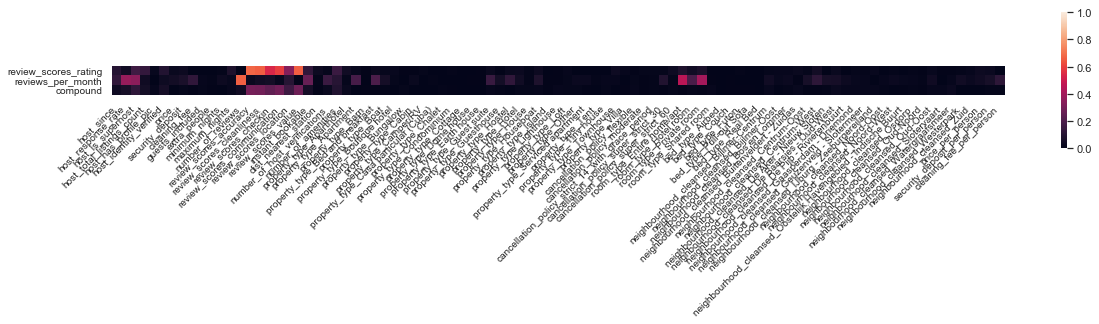

In [29]:
f = FeaturesTools()
corr1 = f.correlationAnalysis(df = df_features_w_metrics, method = 'pearson', plotMatrix = False, printTopCorrelated = False)

metrics_vs_features = corr1.loc[:, df_success_metrics.columns].drop(df_success_metrics.columns).abs()
chart = sns.heatmap(metrics_vs_features.transpose(), square=True, cbar_kws={"shrink": .5}, xticklabels=True, yticklabels=True, vmin=0, vmax=1)
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.tick_params(labelsize=10)
chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right')
plt.show()

By plotting the correlation of the metrics with the features we observe that:
- as expected the score features are highgly correlated with the score metrix. 
- the other features are not very highly correlated with the metrics. The higest correlated ones are expected tobe the most important in the RF analysis since both correlation and RF are linear models.
- the feature number_of_reviews is highly correlated with the metric reviews_per_month. This is expected since one depends on the other. 

--> SINCE THE SCORES FEATURES ARE HIGHLY CORRELATED WITH THE METRIC REVIEW_SCORES_RATING, THEY ARE REMOVED FROM THE DF.

--> SINCE THE number_of_reviews FEATURE IS HIGHLY CORRELATED WITH THE METRIC REVIEW_SCORES_RATING, IT IS REMOVED FROM THE DF.

#### REMOVING THE ABOVE MENTIONED FEATURES FROM THE DATASET

In [31]:
rating_remove = rating_features
rating_remove.remove('review_scores_rating')

df_features_w_metrics = df_features_w_metrics.drop(columns = rating_remove)
df_features_w_metrics = df_features_w_metrics.drop(columns = 'number_of_reviews')

> Running correlationAnalysis...



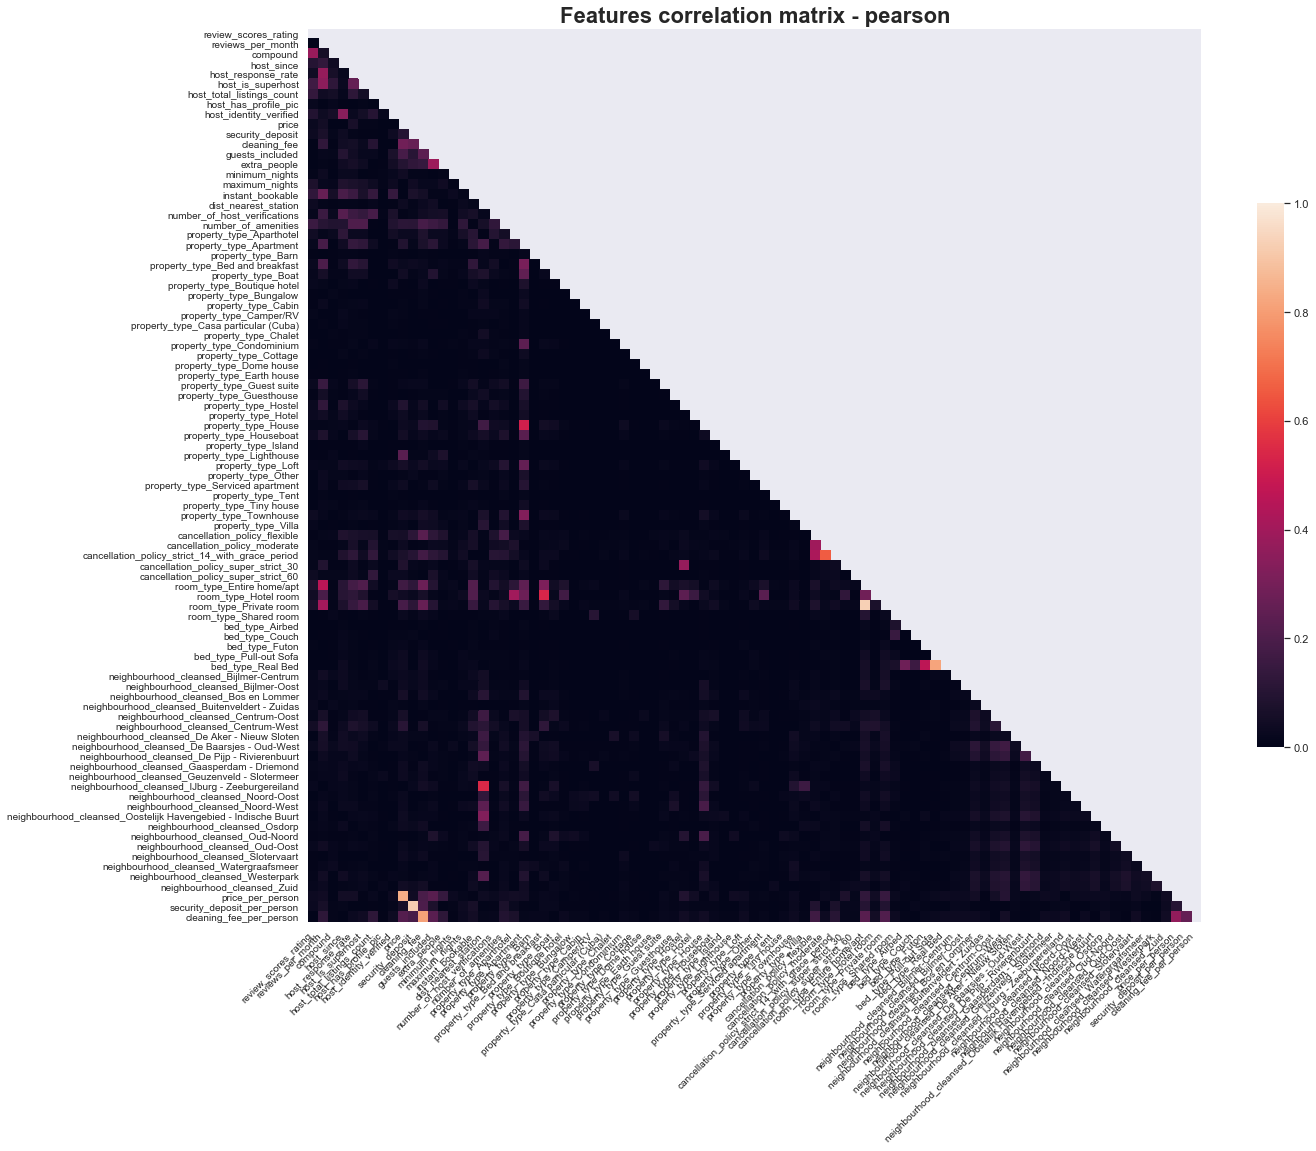

The 20 less correlated features are:
neighbourhood_cleansed_Centrum-West            property_type_Townhouse                          0.000001
property_type_Lighthouse                       host_total_listings_count                        0.000002
host_total_listings_count                      property_type_Lighthouse                         0.000002
guests_included                                neighbourhood_cleansed_Osdorp                    0.000005
neighbourhood_cleansed_Osdorp                  guests_included                                  0.000005
minimum_nights                                 neighbourhood_cleansed_De Aker - Nieuw Sloten    0.000009
neighbourhood_cleansed_De Aker - Nieuw Sloten  minimum_nights                                   0.000009
number_of_host_verifications                   neighbourhood_cleansed_Bijlmer-Centrum           0.000017
neighbourhood_cleansed_Bijlmer-Centrum         number_of_host_verifications                     0.000017
property_type_Cond

In [32]:
f = FeaturesTools()
corr1 = f.correlationAnalysis(df = df_features_w_metrics, method = 'pearson', plotMatrix = True, printTopCorrelated = True)


This heatmap of the Pearson correlation matrix shows that most of the features are mostly uncorrelated, meaning that most features bring information that can not be obtained from other features.

Few of them are highly correlated like `price_per_person` with `price`, or `security_deposit_per_person`and `security_deposit` which is expected as they respectively represent the same kind of measures. 


> Running correlationAnalysis...



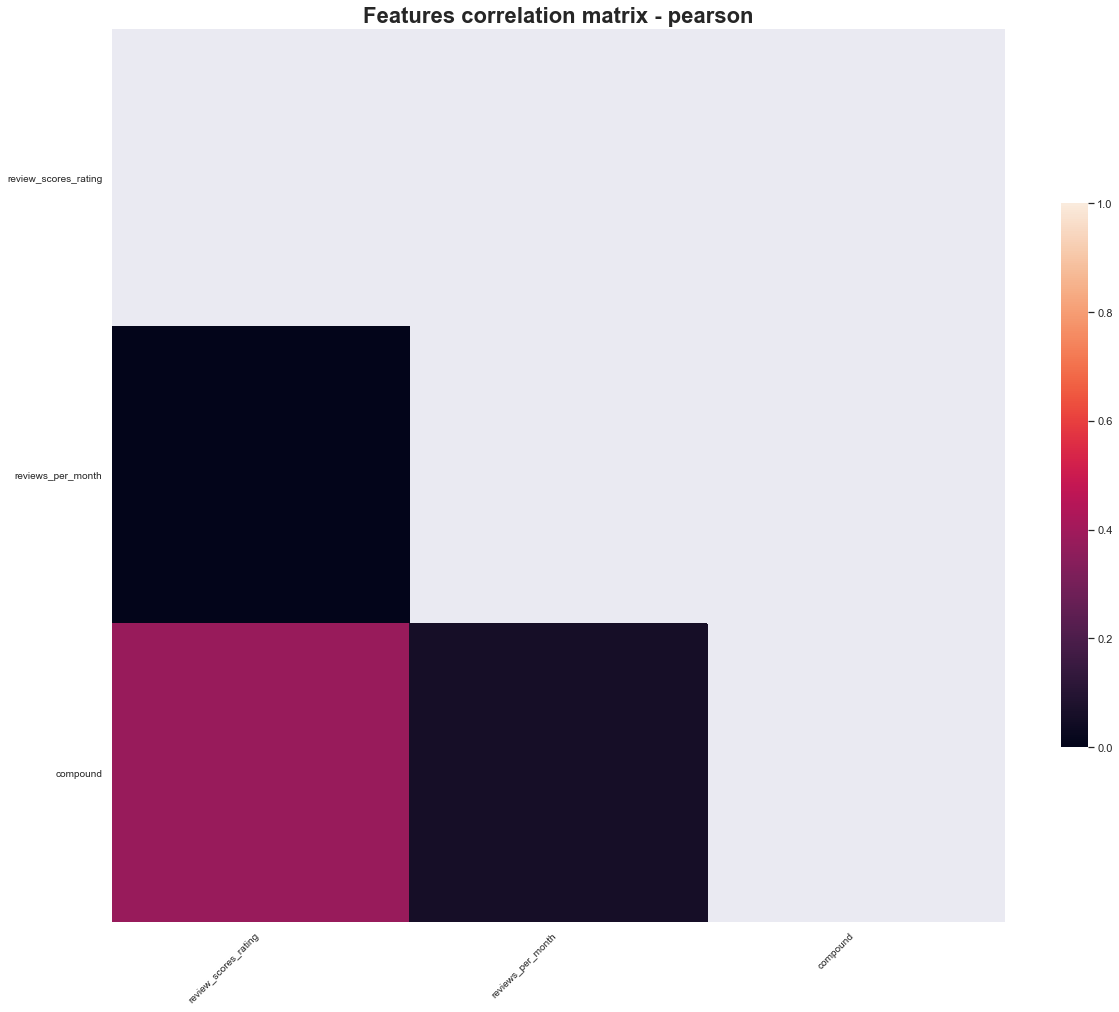

In [33]:
corr2 = f.correlationAnalysis(df = df_success_metrics, method = 'pearson', plotMatrix = True, printTopCorrelated = False)

The metrics show very little correlation with one another. This is very encouraging. Indeed, the less metrics are correlated, the more information we gain from the analysis since a low part of the same variance is explained by more than one metric.

Now that we have explored the data and tested the data-cleaning procedure, we can create a function to perform this data-cleaning procedure automatically. Such function is defined in the file [prepare_clean_data.py](https://github.com/vonalven/airbnb_ada_project/blob/master/src/prepare_clean_data.py)

## RANDOM FOREST

First, the preprocessing methods are evaluated. We perform the test only for all the metrics. Then the best method will be selected for all the following analyses.

In [34]:
random_seed = 1

In [36]:
df_success_metrics.columns.tolist()

['review_scores_rating', 'reviews_per_month', 'compound']


Running for metric review_scores_rating ...


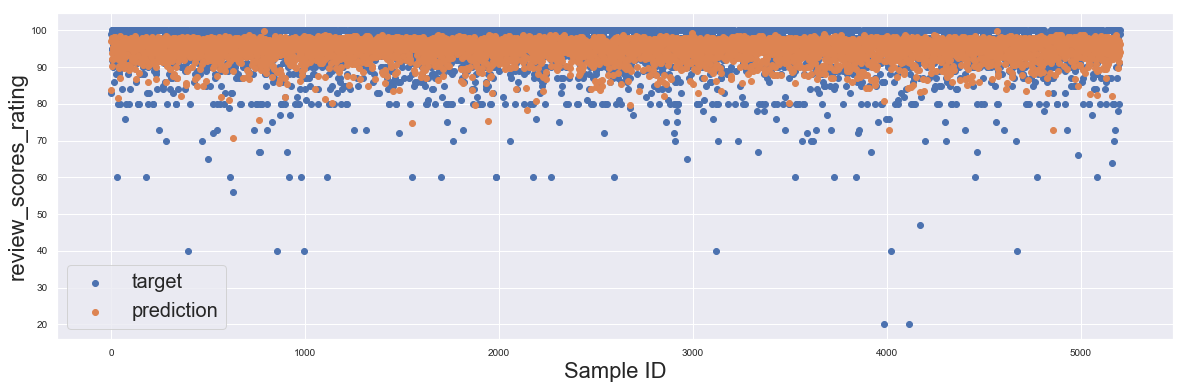


Running for metric reviews_per_month ...


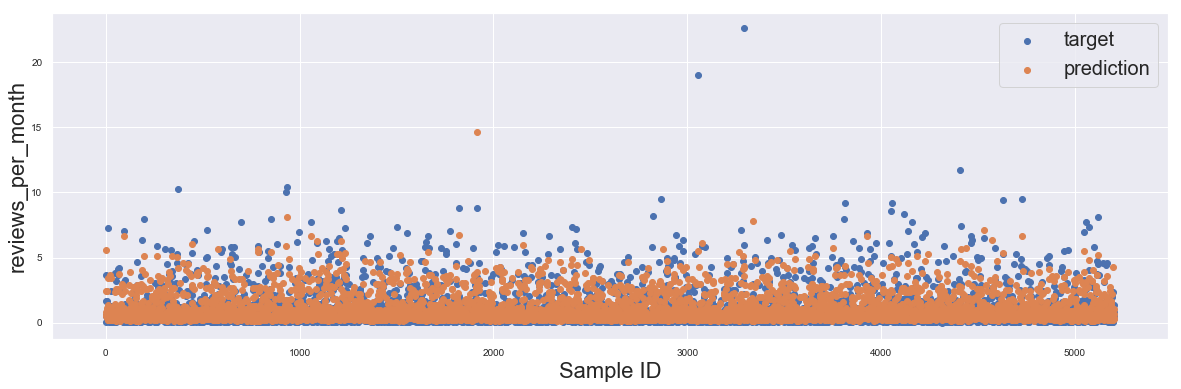


Running for metric compound ...


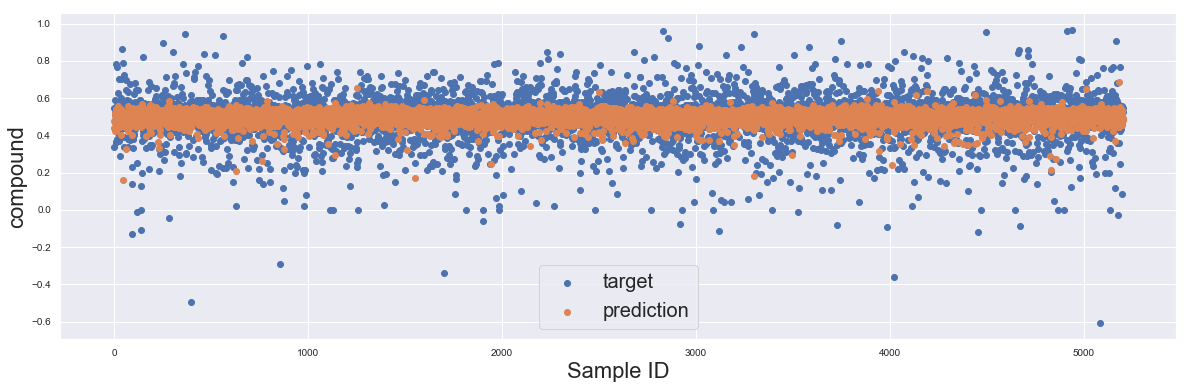

In [37]:
all_metric_errors = pd.DataFrame()

for metric in df_success_metrics.columns:
    df = df_features_w_metrics.copy().drop(columns = df_success_metrics.columns.difference([metric]))
    print('\nRunning for metric %s ...'%(metric))
    with HiddenPrints():
        print('\n--------------------------\n--------- RAW DATA -------\n--------------------------\n')
        f = FeaturesTools(df, metric, random_seed = random_seed)
        df_importance, df_err, rf = f.randomForestAnalysis(plotResults = [False, False, True, False], tuneModelParameters = False)
        print('\n--------------------------\n------ NORMALIZATION -----\n--------------------------\n')
        f = FeaturesTools(df, metric, random_seed = random_seed)
        processed_feat = f.preprocess_features(preprocessing_type = 'normalize')
        f = FeaturesTools(processed_feat, metric, random_seed = random_seed)
        df_importance, df_err_norm, rf = f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False)
        print('\n--------------------------\n----- STANDARDIZATION -----\n--------------------------\n')
        f = FeaturesTools(df, metric, random_seed = random_seed)
        processed_feat = f.preprocess_features(preprocessing_type = 'standardize')
        f = FeaturesTools(processed_feat, metric, random_seed = random_seed)
        df_importance, df_err_stand, rf = f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False)
        print('\n--------------------------\n-- ROBUST STANDARDIZATION -\n--------------------------\n')
        f = FeaturesTools(df, metric, random_seed = random_seed)
        processed_feat = f.preprocess_features(preprocessing_type = 'standardize_robust')
        f = FeaturesTools(processed_feat, metric, random_seed = random_seed)
        df_importance, df_err_stand_robust, rf = f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False)
        print('\n--------------------------\n------- UNIT SCALING ------\n--------------------------\n')
        f = FeaturesTools(df, metric, random_seed = random_seed)
        processed_feat = f.preprocess_features(preprocessing_type = 'scale_unit')
        f = FeaturesTools(processed_feat, metric, random_seed = random_seed)
        df_importance, df_err_scale_unit, rf = f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False)


    # Cration of a df with the errors obtained with all types of features preprocess
    df_error = pd.concat([df_err, df_err_norm, df_err_stand, df_err_stand_robust, df_err_scale_unit], keys=['NO_PREPROCESSING', 'NORMALISATION', 'STANDARDIZATION','ROBUST STANDARIZATION','UNIT SCALING'])
    #df_error.columns = df_error.columns.values + '_' + metric
    all_metric_errors = pd.concat([all_metric_errors, df_error], axis = 1)


In [38]:
all_metric_errors

review_scores_rating  \
NO_PREPROCESSING      R^2 error                      1.242272e-01   
                      MSE error                      3.631462e+01   
                      MAE error                      3.967478e+00   
                      Median Absolute error          2.880000e+00   
NORMALISATION         R^2 error                      1.300694e-01   
                      MSE error                      2.289927e-07   
                      MAE error                      3.135872e-04   
                      Median Absolute error          2.322600e-04   
STANDARDIZATION       R^2 error                      1.192684e-01   
                      MSE error                      9.078032e-01   
                      MAE error                      6.273492e-01   
                      Median Absolute error          4.540687e-01   
ROBUST STANDARIZATION R^2 error                      1.202425e-01   
                      MSE error                      7.444866e-01   
                      MAE error                      5.678532e-01   
                      Median Absolute error          4.114286e-01   
UNIT SCALING          R^2 error                      1.252082e-01   
                      MSE error                      5.667803e-03   
                      MAE error                      4.966368e-02   
                      Median Absolute error          3.625000e-02   

                                             reviews_per_month  compound  
NO_PREPROCESSING      R^2 error                       0.519779 -0.001409  
                      MSE error                       0.897921  0.014007  
                      MAE error                       0.543222  0.079762  
                      Median Absolute error           0.284200  0.052191  
NORMALISATION         R^2 error                       0.519998  0.000341  
                      MSE error                       0.000018  0.000003  
                      MAE error                       0.002416  0.001183  
                      Median Absolute error           0.001254  0.000778  
STANDARDIZATION       R^2 error                       0.518568  0.000358  
                      MSE error                       0.474295  1.072307  
                      MAE error                       0.395226  0.697179  
                      Median Absolute error           0.207453  0.459062  
ROBUST STANDARIZATION R^2 error                       0.518855 -0.000765  
                      MSE error                       1.275014  1.309585  
                      MAE error                       0.647044  0.771564  
                      Median Absolute error           0.336667  0.507278  
UNIT SCALING          R^2 error                       0.521416  0.000660  
                      MSE error                       0.001556  0.005582  
                      MAE error                       0.022635  0.050312  
                      Median Absolute error           0.011913  0.032856

The above graphs show the predicted and the true values for each of the metrics. What stands out from the above results is that: 
- for review_scores_rating, the best performance is obtained with the row data and the error is very very low, regardless of the type of error that is used.
- for reviews_per_month, the performance is quite good in all the cases! 
- for compound, we observe on the plot a lot of "outliers". In this case, an evaluation metric that is robust to the outliers is therefore to be considered when comparing the performances.

Thus, we can formulate the following conclusions, that will be used for the rest of the project and that are valid for all metrics:
- No preprocessing method is better than another by far. Indeed, they all provide satisfying results. Furthermore, error values are not comparable as they are based on different scales.
- Choosing to perform robust standardisation happens to be an adequate pick as this reduce the impact of outliers.


**Summarizing**, we will use robust standardization of the data for all the 3 metrics!

### RANDOM FOREST ANALYSIS FOR HYPERPARAMETER TUNING
Tuning is performed through a sklearn random grid search. Because of the number of parameters and the size of the datasets, this optimization is very slow. To optimize the random forest models for the next analyses we perform here the following:
- All the data sets for all the cities are very similar: they have the same features and a similar range of values. Therefore, since the RF parameters are more "feature-dependent" (max_features, max_depth, ...) and less based on the actual samples values (such dependent parameters could be for example regularization weights, ...), we optimize the hyperparameters of the model once and we use them for all the next analyses.
- For comparison we run the parameters optimization for 4 cities: Amsterdam, Prague, New York, and Hong-Kong. We selected those cities to have an international representative group (Europe, Asia, USA). Amsterdam was selected because this is the city that we use as test to develop the code. 
- The optimization is done by selecting the target "reviews_per_month". By this way, there is no need to compute the compound metric (very long!)

To tune the hyperparameters, the used error metric is MSE. The tested parameters are detailed in *features_tools.randomForestAnalysis* which can be found in the file [features_tools.py](https://github.com/vonalven/airbnb_ada_project/blob/master/src/feature_tools.py).


In [41]:
random_seed = 1

data_location_airbnb     = '../data/DataSet'
data_location_transports = '../data/Transports'
output_location          = '../data/AllCitiesOutput'

city_files     = ['2019-09-14_Amsterdam_listings_detailed.csv', '2019-09-12_New York City_listings_detailed.csv',
                  '2019-09-20_Hong Kong_listings_detailed.csv', '2019-09-30_Prague_listings_detailed.csv']
stations_files = ['amsterdam_stations.geojson', 'new-york_stations.geojson',
                  'hong-kong_stations.geojson', 'prague_stations.geojson']

# city_files = ['2019-09-30_Prague_listings_detailed.csv']
# stations_files = ['prague_stations.geojson']

for city, station in zip(city_files, stations_files):
    city_name            = city.split('_')[1]
    df_listings_detailed = pd.read_csv(data_location_airbnb + '/' + city, low_memory = False)
    
    print('Running hyperparameters tuning analysis for city %s ...'%(city_name))
    
    # add distance to stations
    df_station           = geojson_to_dataframe(data_location_transports + '/' + station)    
    stations_coord       = get_station_coord(df_station)
    listings_coord       = get_listing_coord(df_listings_detailed)
    min_distances        = dist_to_nearest_station_haversine(stations_coord, listings_coord)
    df_listings_detailed['dist_nearest_station'] = min_distances
    
    with HiddenPrints():
        # data cleaning
        df_success_metrics = df_listings_detailed[['review_scores_rating', 'id']].set_index('id')
        df_cleaned         = cleanAndMergeData(df_listings_detailed, df_success_metrics, use_neigh = True)
        
        # random forest analysis, single target
        df_importance_simple = pd.DataFrame()
        df_error_simple      = pd.DataFrame()
        
        # robust standardization
        f = FeaturesTools(df_cleaned, 'review_scores_rating', random_seed = random_seed)
        df_cleaned_processed = f.preprocess_features(preprocessing_type = 'standardize_robust')
        
        # hyperparameters tuning
        f = FeaturesTools(df_cleaned_processed, 'review_scores_rating', random_seed = random_seed)
        df_importance_tuned, df_err_tuned, rf_tuned, _, best_parameters_tuned = \
            f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = True, 
                                   saveFigures = [True, True, True, False], 
                                   saveTag = city_name + 'tuning' + '_review_scores_rating',
                                   saveLocation = output_location)
        
        # without hyperparameter tuning (for performance comparison)
        df_importance_default, df_err_default, rf_default = \
            f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False,
                                   saveFigures = [True, True, True, False], 
                                   saveTag = city_name + 'no_tuning' + '_review_scores_rating',
                                   saveLocation = output_location)
        
        # save
        np.save(output_location + '/' + city_name + '_review_scores_rating_best_hyperparams', best_parameters_tuned)
        df_importance_tuned.to_csv(output_location + '/' + city_name + '_tuned_df_importance.csv')
        df_err_tuned.to_csv(output_location + '/' + city_name + '_tuned_df_error.csv')
        df_importance_default.to_csv(output_location + '/' + city_name + '_not_tuned_df_importance.csv')
        df_err_default.to_csv(output_location + '/' + city_name + '_not_tuned_df_error.csv')

Running hyperparameters tuning analysis for city Amsterdam ...
Running hyperparameters tuning analysis for city New York City ...
Running hyperparameters tuning analysis for city Hong Kong ...
Running hyperparameters tuning analysis for city Prague ...


### Analyse the results:

In [15]:
best_params      = ['Amsterdam_review_scores_rating_best_hyperparams.npy', 
                    'New York City_review_scores_rating_best_hyperparams.npy',
                    'Hong-Kong_review_scores_rating_best_hyperparams.npy',
                    'Prague_review_scores_rating_best_hyperparams.npy']
cities           = ['Amsterdam', 'New York', 'Hong-Kong', 'Prague']
errors_not_tuned = ['Amsterdam_not_tuned_df_error.csv', 'New York City_not_tuned_df_error.csv',
                    'Hong-Kong_not_tuned_df_error.csv', 'Prague_not_tuned_df_error.csv']
errors_tuned     = ['Amsterdam_tuned_df_error.csv', 'New York City_tuned_df_error.csv', 
                    'Hong-Kong_tuned_df_error.csv', 'Prague_tuned_df_error.csv']
print('The best RF hyperparameters and the corresponding RF performances are:')
for city, params, err_not_tuned, err_tuned in zip(cities, best_params, errors_not_tuned, errors_tuned):
    dict_param = np.load(output_location + '/' + params, allow_pickle='TRUE')
    print('\n> ' + city +':')
    print(dict_param)
    err = pd.read_csv(output_location + '/' + err_not_tuned).set_index('Unnamed: 0')
    err = pd.concat([err, pd.read_csv(output_location + '/' + err_tuned).set_index('Unnamed: 0')], axis = 1)
    err.index.name = 'Error'
    err.columns = err.columns + ['_NOT_TUNED', '_TUNED']
    print(tabulate(err, headers='keys', tablefmt='psql', numalign = 'center', stralign = 'center'))


The best RF hyperparameters and the corresponding RF performances are:

> Amsterdam:
{'warm_start': False, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1}
+-----------------------+----------------------------------+------------------------------+
|         Error         |  review_scores_rating_NOT_TUNED  |  review_scores_rating_TUNED  |
|-----------------------+----------------------------------+------------------------------|
|       R^2 error       |            0.0803128             |           0.025588           |
|       MSE error       |             0.747542             |           0.792023           |
|       MAE error       |             0.572812             |           0.609365           |
| Median Absolute error |             0.425714             |           0.544837           |
+-----------------------+----------------------------------+------------------------------+

> New York:
{'warm_start': True, 'n_estimators'

From the previous analysis it can be observed that:
- The best hyperparameters found for each city slightly change, even if the data in the data-sets are very similar! (Same ranges, same features, ...). It would be hard to find a general set of optimized parameters that fit for all the cities without running optimization at each time (computationally inefficient, expensive)
- Already for the default model the error is very low! Therefore, tuning is not really necessary.
- The default model generally performs better. This could be due to the fact that the random grid search could not have explored all the combinations of the input parameters. A more exhaustive search could be performed with a cross validation. But since in this case the error are already very low with the default parameters, this is not worth. In fact, to tune the hyperparameters with a random grid search for a large data set (New York) it takes approximatively 5-6 hours on a laptop!

For those reasons, the default parameters for the RF models are used for the following analyses. Those parameters are:
- warm_start = False
- n_estimators = 100
- min_samples_split = 2
- min_samples_leaf = 1
- max_features = 'auto'
- max_depth = None
- bootstrap = True

### RANDOM FOREST ANALYSIS FOR ALL THE METRICS

Now that the hyperparameters were optimized and the is was assessed that no preprocessing is requires, RF analysis can be run again. This time for all the metrics and to generate the figures and results. To do so, single-target RF models are ran to later test a multi-target RF model.

Here, a Random Forest algorithm is used to classify features according to their importance and to study the influence of features over the overall prediction. This is of use to, for example, compare how the weight of different features changes for different metrics. The use of Random Forests could be extended to compare the results for different neibourhoods or even cities. 

In [37]:
# for all these step random_seed is set to 1
random_seed = 1

#### A. SINGLE-TARGET MODELS

> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.088921

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+
|                       |  review_scores_rating  |
|-----------------------+------------------------|
|       R^2 error       |        0.120243        |
|       MSE error       |        0.744487        |
|       MAE error       |        0.567853        |
| Median Absolute error |        0.411429        |
+-----------------------+------------------------+


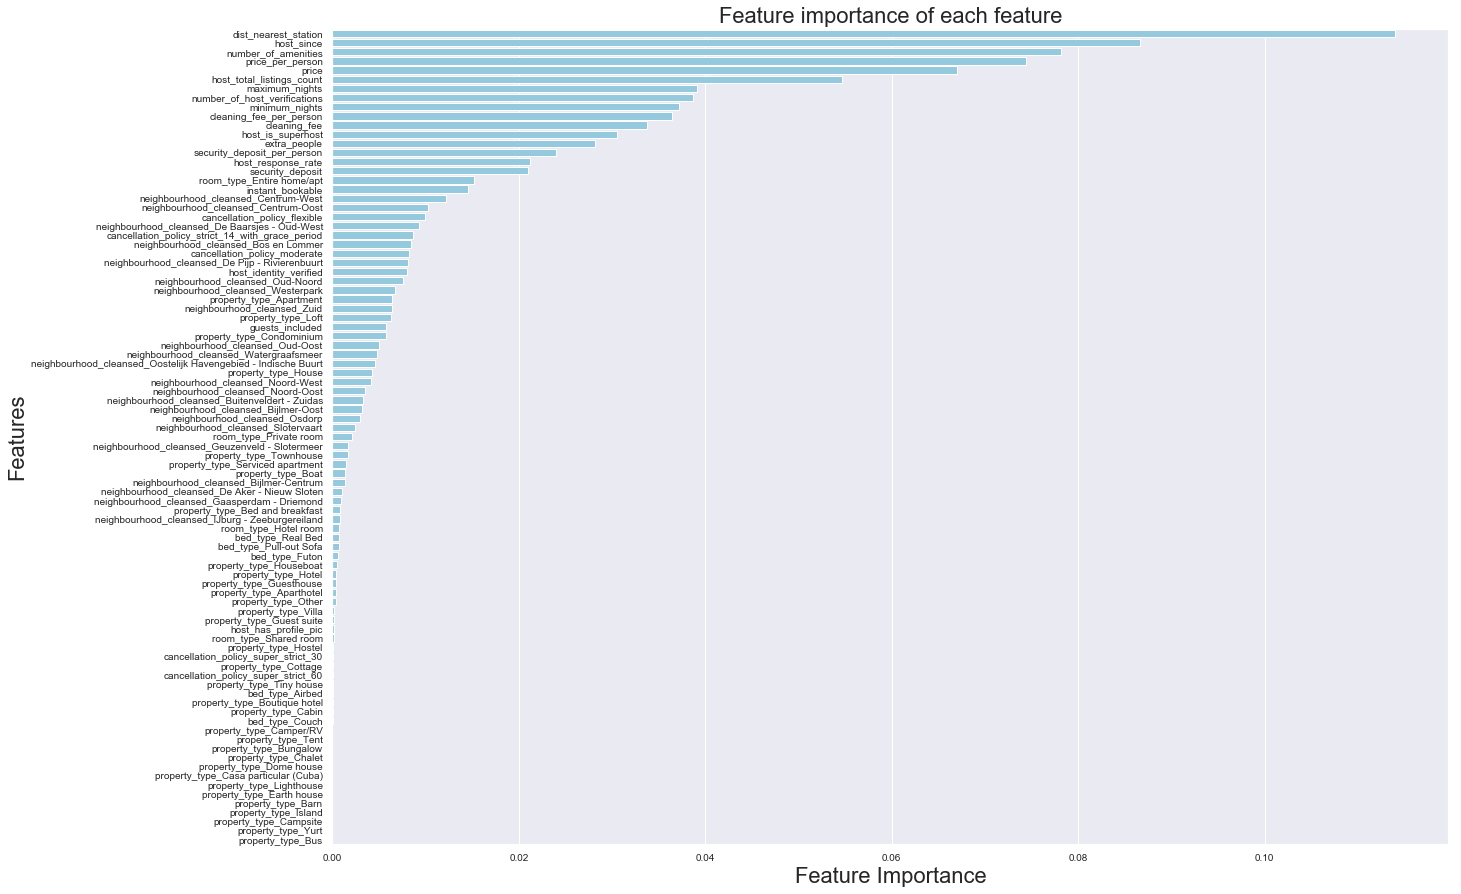

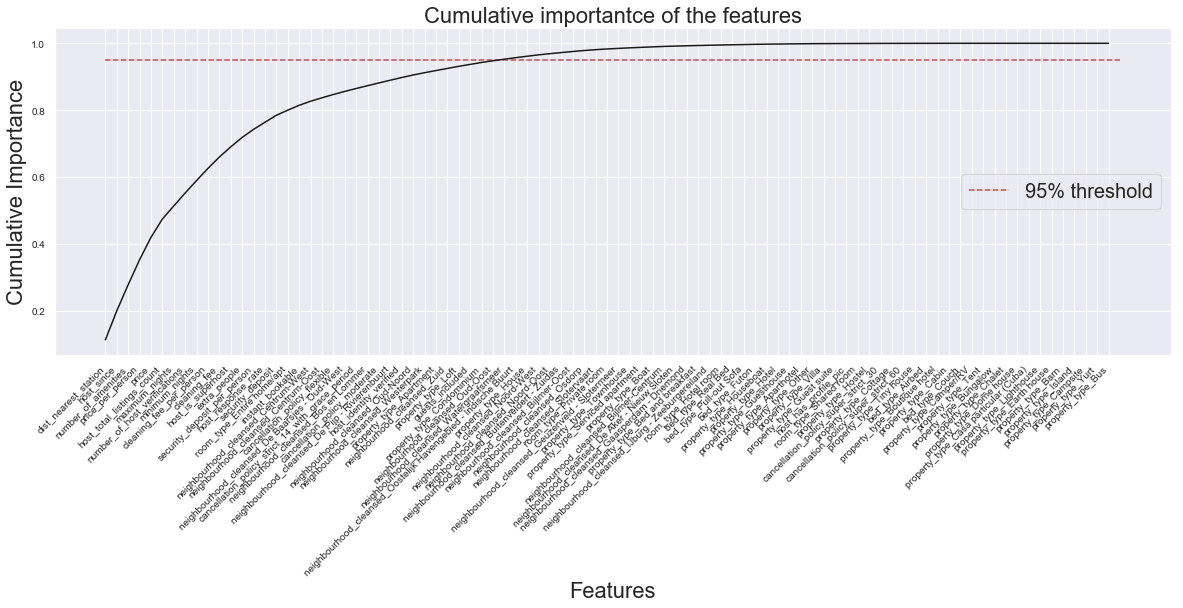

In [43]:
df_importance1, df_err1, rf1 = perform_rf_simple(df_features_w_metrics, 
                                                 df_success_metrics, random_seed = random_seed, 'review_scores_rating')


> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.485268

> Performances comparison for the target(s) variables:

+-----------------------+---------------------+
|                       |  reviews_per_month  |
|-----------------------+---------------------|
|       R^2 error       |      0.518855       |
|       MSE error       |       1.27501       |
|       MAE error       |      0.647044       |
| Median Absolute error |      0.336667       |
+-----------------------+---------------------+


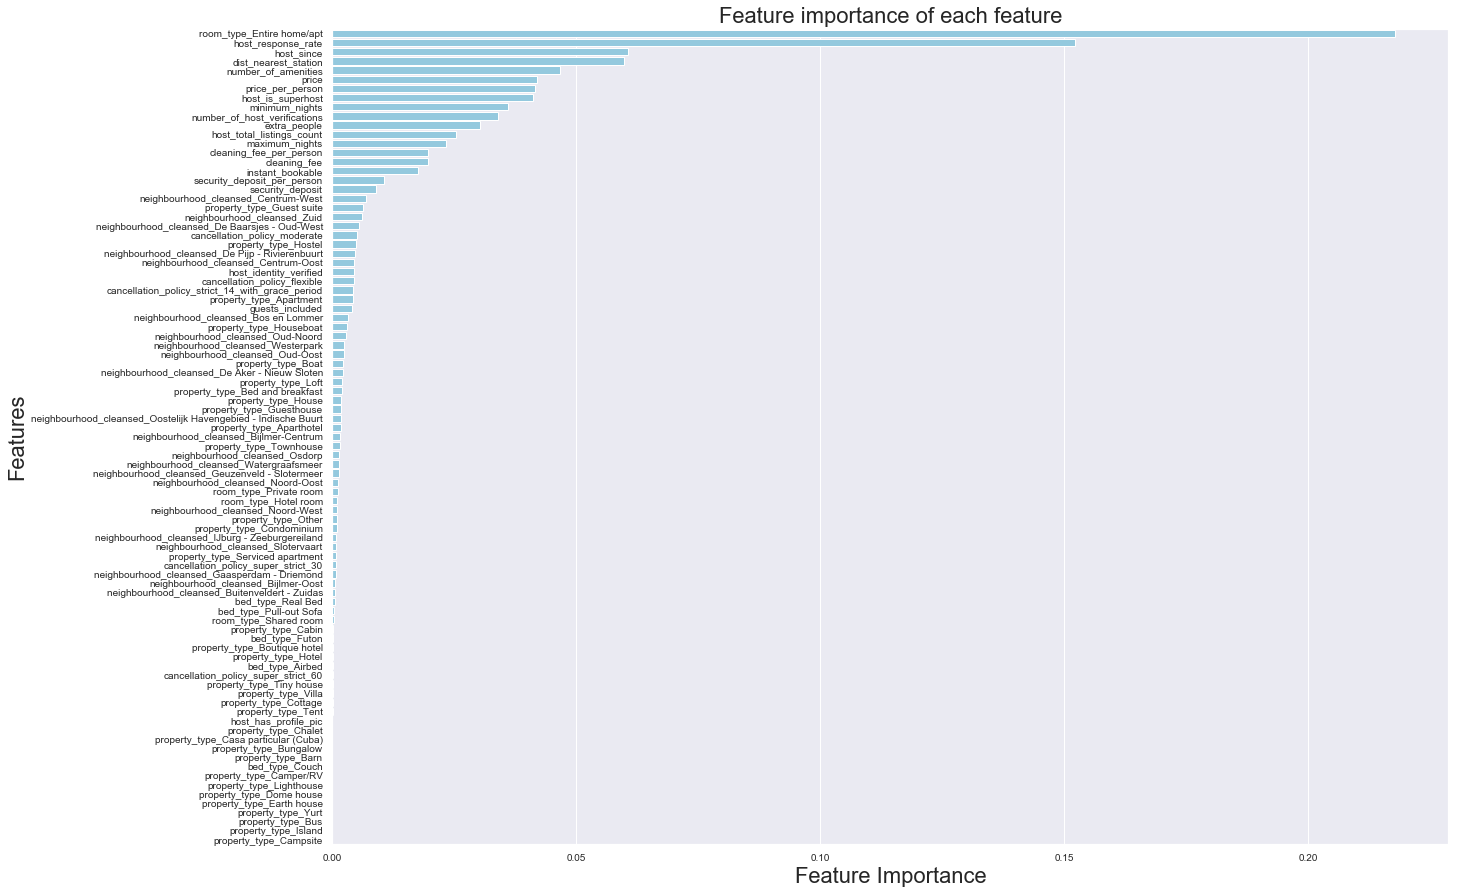

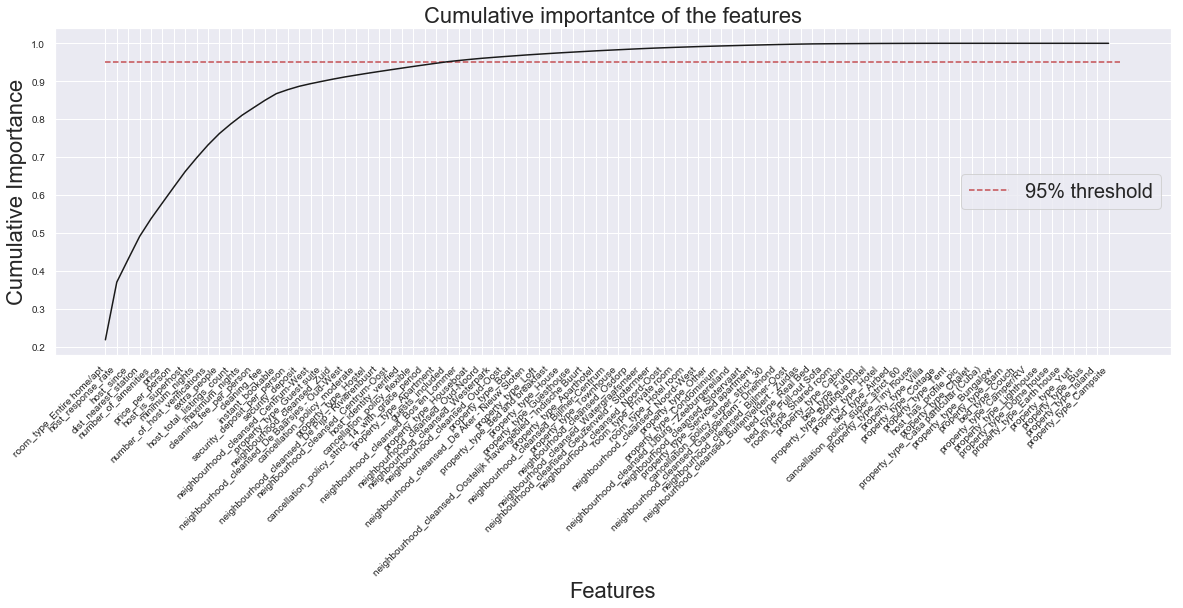

In [44]:

df_importance2, df_err2, rf2 = perform_rf_simple(df_features_w_metrics, df_success_metrics, 
                                                 random_seed = random_seed, 'reviews_per_month')


> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          -0.022685

> Performances comparison for the target(s) variables:

+-----------------------+--------------+
|                       |   compound   |
|-----------------------+--------------|
|       R^2 error       | -0.000764792 |
|       MSE error       |   1.30958    |
|       MAE error       |   0.771564   |
| Median Absolute error |   0.507278   |
+-----------------------+--------------+


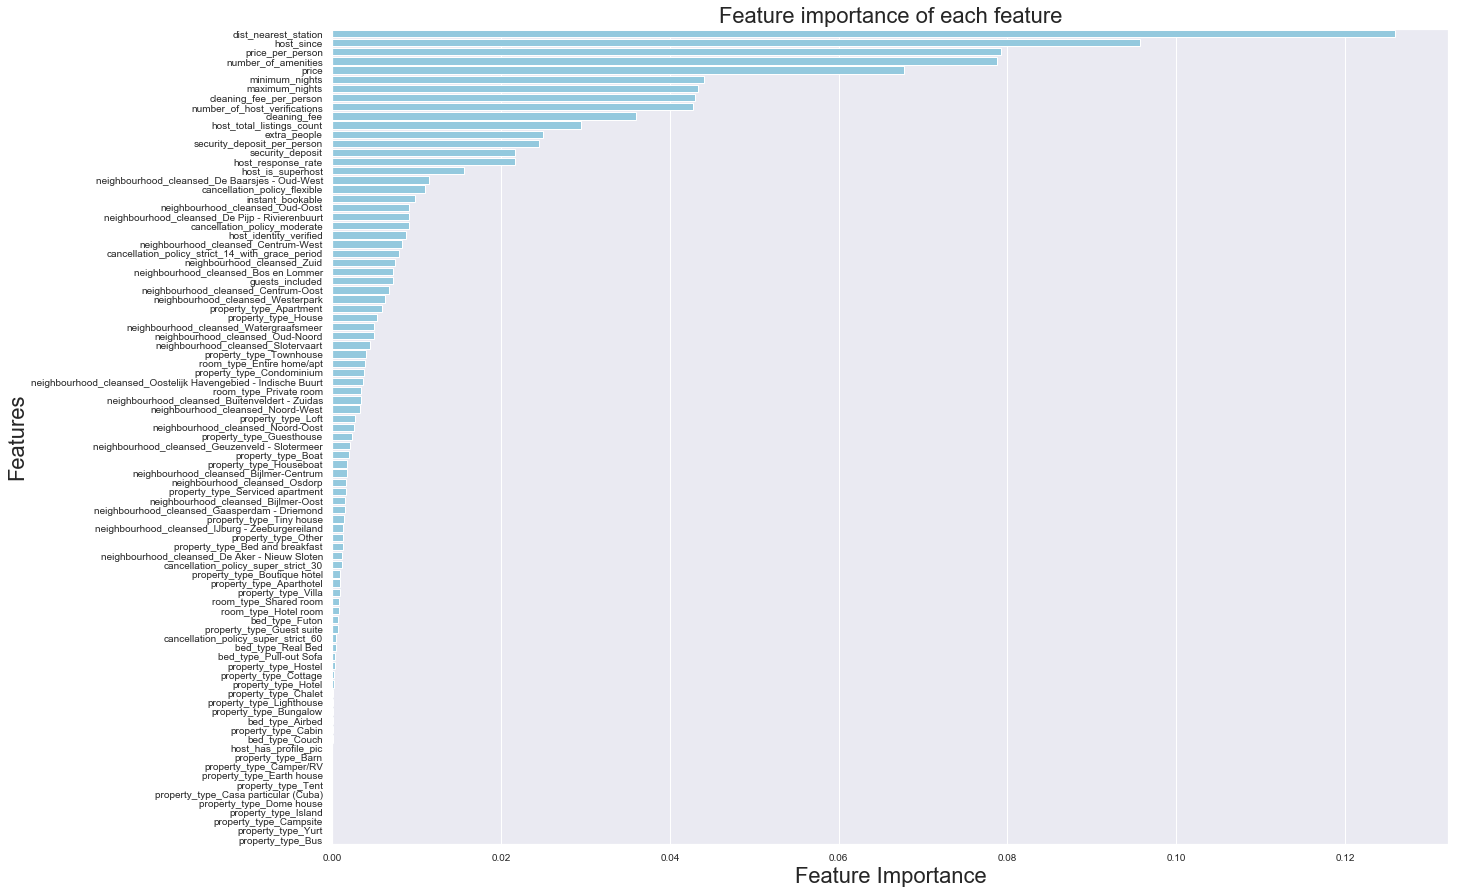

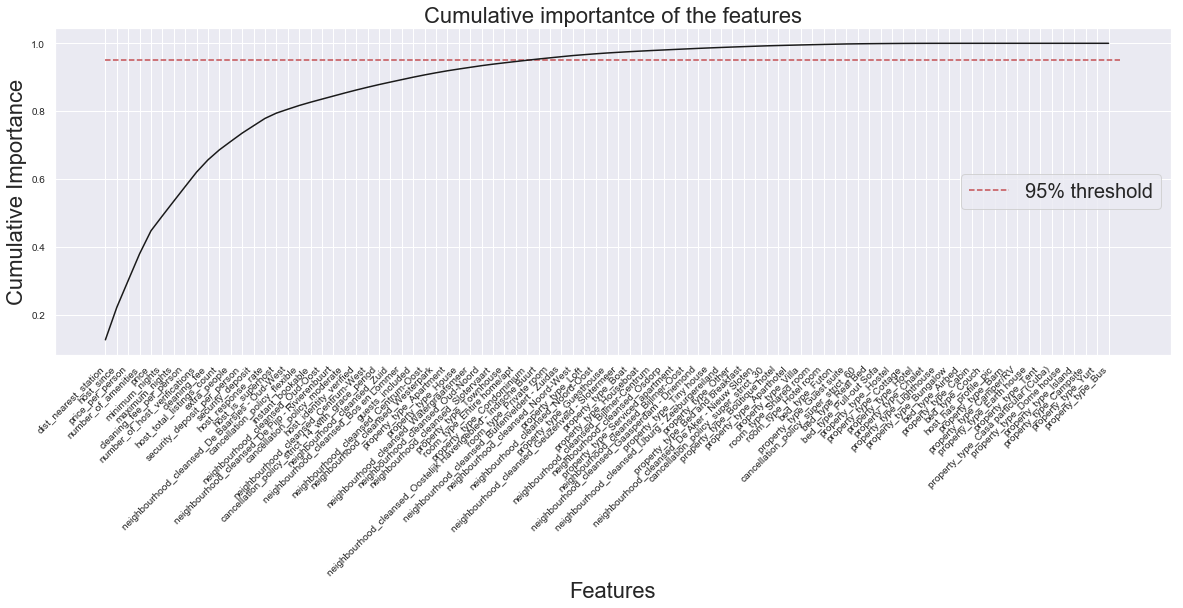

In [45]:
df_importance3, df_err3, rf3 = perform_rf_simple(df_features_w_metrics, df_success_metrics, 
                                                 random_seed = random_seed,  'compound')


By plotting the relevance of features for each metric, we first observe that the importance of the features for the three metrics have different ranges. Indeed, for `review_score_rating` and `compound`, values are within 0.0 and 0.11, while the importance of the features for the metric `reviews_per_month` ranges from 0.0 to 0.5. This wider range results from a single feature: `number_of_reviews`, which can be expected as the metric we chose to represent the demand for a listing (`reviews_per_month`) is very likely to have been calculated from this particular feature. If we exclude this feature, we notice that all the following important features for `reviews_per_month` are in the range 0.0 to 0.11, similarly to the other metrics. 

Moreover, we notice that features describing types of property that are atypical for a city are found in the bottom of the ranking for all the metrics. This is most likely because none of these types of properties are offered in this city.

We set a cumulative importance threshold at 95%, as the plateau is more or less reached above this amount. Features that come after the threshold has been reached have such a small importance that they could potentially be discarded. 

##### DEFINING A FUNCTION ABLE TO BUILD A DATAFRAME THAN CAN BE USED AS INPUT FOR SANKEY PLOTS


This input df has a quite complex structure. To avoid at each time to write an error-prone code, the following function is defined. Such function is defined in [main_functions.py](https://github.com/vonalven/airbnb_ada_project/blob/master/src/main_functions.py)

##### BUILDING AN EXAMPLE OF SANKEY PLOT OF AMSTERDAM FEATURES IMPORTANCES FOR ALL THE METRICS

> Running interactive_sankey...



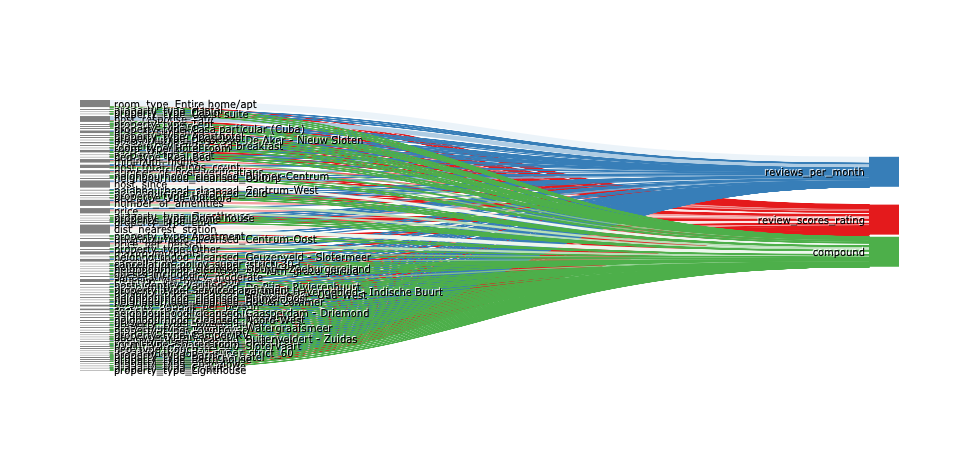

In [61]:
list_of_df           = [df_importance1, df_importance2, df_importance3]
list_of_targets      = ['review_scores_rating', 'reviews_per_month', 'compound']
column_weights_name  = 'feature_importance'
column_features_name = 'feature'

df_sankey = build_sankey_input_df(list_of_df, list_of_targets, column_weights_name, column_features_name)

# do sankey plot
f.interactive_sankey(df_sankey, '') 

##### BUILDING AN EXAMPLE OF SANKEY PLOT OF AMSTERDAM FEATURES IMPORTANCE FOR ALL THE METRICS SETTING A THRESHOLD ON THE CONNECTIONS WEIGHT ( = ON THE FEATURES IMPORTANCE)

> Running interactive_sankey...



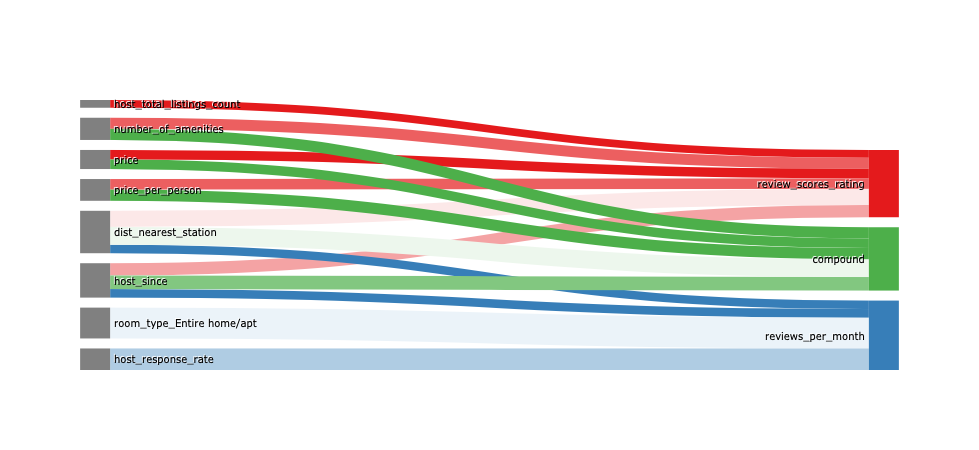

In [65]:
df_sankey = build_sankey_input_df(list_of_df, list_of_targets, column_weights_name, 
                                  column_features_name, weight_treshold = 0.05)
# do sankey plot
f.interactive_sankey(df_sankey, '') 

The first interactive tree allows the visualization of the contribution of each feature to each metric. The second one only shows the most important ones to allow better visualization. 

When moving your cursor on the color tag of any of the features you can check the value `outgoing_flow_count`, which indicates how many of the metrics this features contributes to. Similarly, you can check the value of `incoming_flow_count` for each metric to see how many of the features contributed to this metric. You can also move features/metrics around by clicking on them and dragging them to another location.

When moving your cursor on the link between a given feature and a metric, you can check the source and the target of this link. Moreover, the width of the link indicates the importance of the contribution.

From these Sankey plots, we observe that features contributing the most to the three metrics are `dist_nearest_station` and `host_since`. Moreover, the other most importants are `price`, `price_per_person`,  `host_total_listings_count`, `number_of_amenities`, `room_type_Entire home/apt` and `host_response_rate`. 

This seems quite accurate, as these features contain typical information potential guests look for when searching for a place to stay.

#### B. MULTI-TARGET MODEL
With the single-target analysis we were able to determine which feature is most important for the prediction of each single metric. But how can we determine the overall importance? We believe the answer lies in using a multi-target model. Here we can state which is the general order of importance of all the features to determines the general quality of a listing. Of course we will expect similarities but some changes with respect to the single metrics can be observed.

> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.175412

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+---------------------+------------+----------+
|                       |  review_scores_rating  |  reviews_per_month  |  compound  |   AVG    |
|-----------------------+------------------------+---------------------+------------+----------|
|       R^2 error       |        0.116904        |        0.521        | -0.0175919 | 0.206771 |
|       MSE error       |        0.747311        |       1.26933       |   1.3316   | 1.11608  |
|       MAE error       |        0.565945        |      0.639897       |  0.775369  | 0.660404 |
| Median Absolute error |          0.41          |      0.325595       |  0.504157  | 0.413251 |
+-----------------------+------------------------+---------------------+------------+----------+


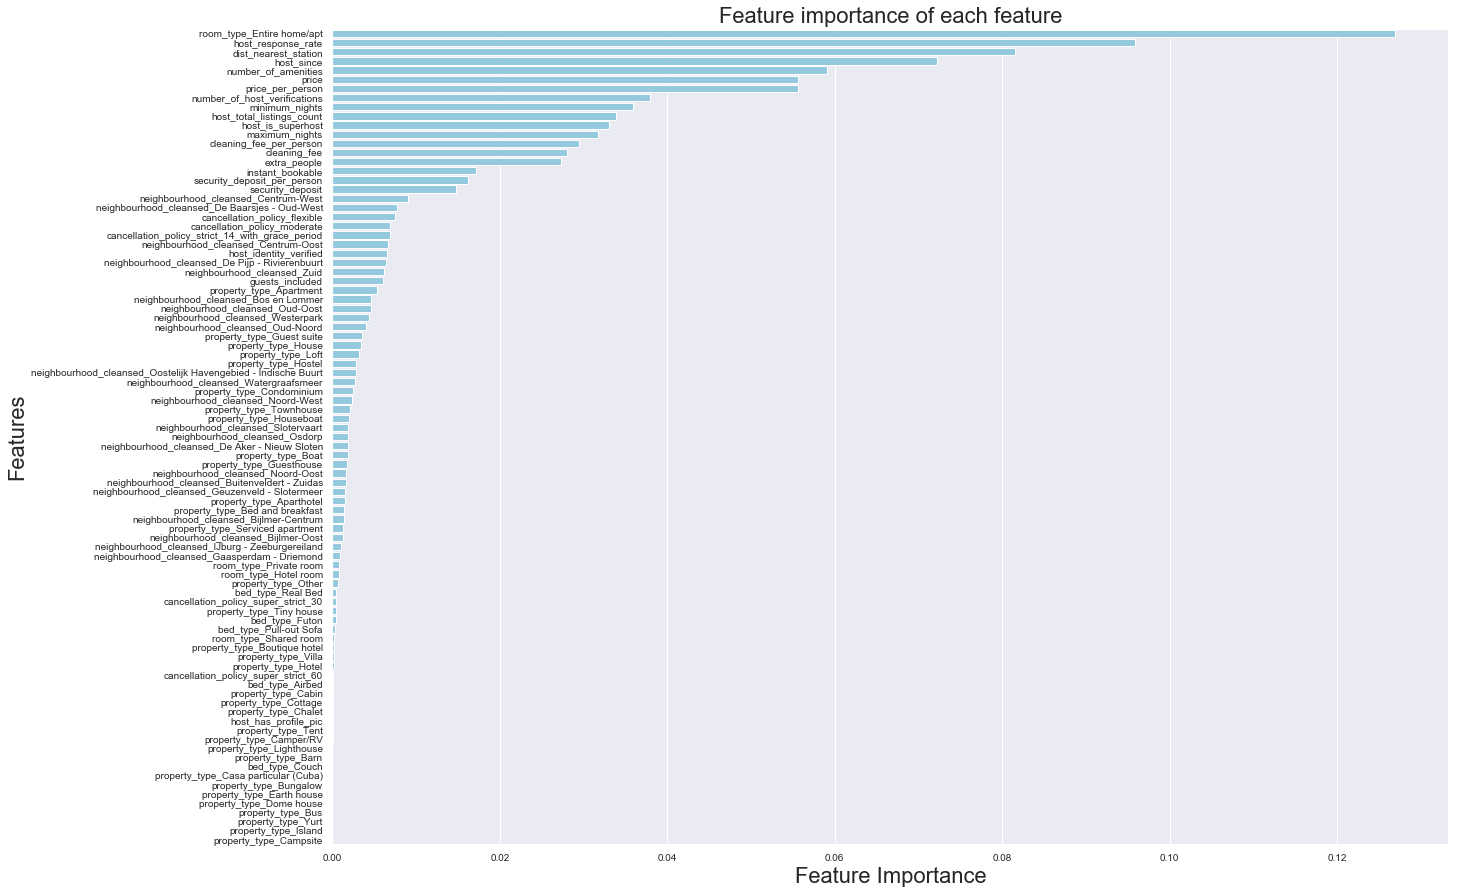

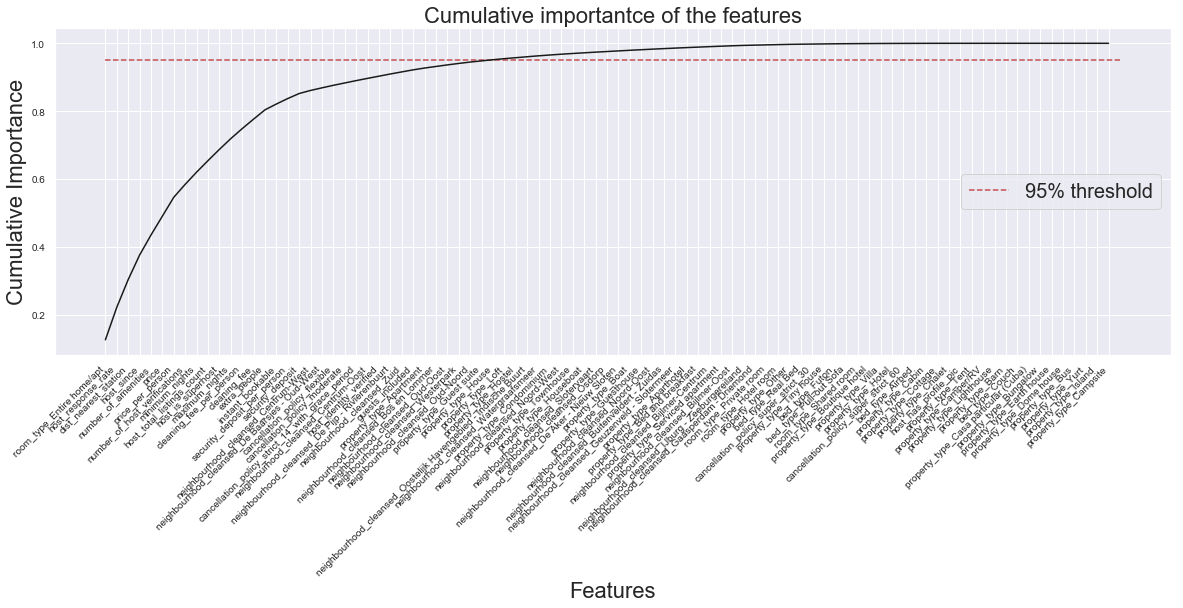

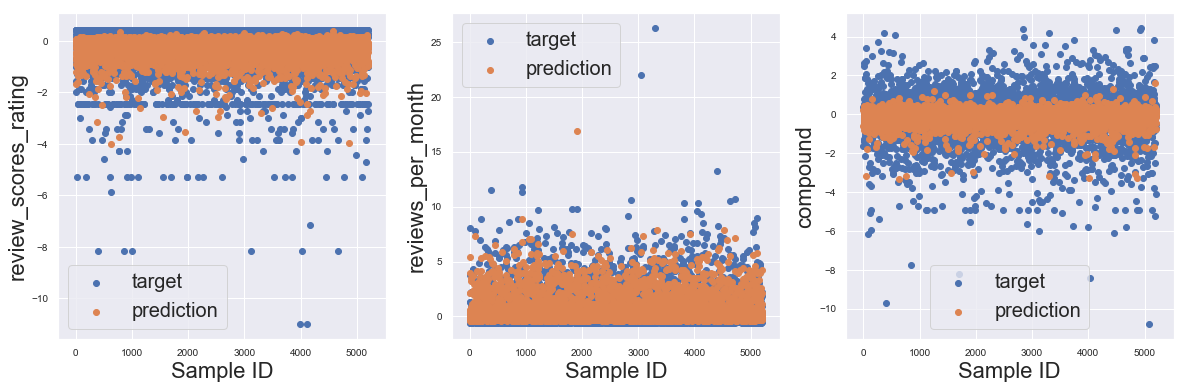

In [67]:
f = FeaturesTools(df_features_w_metrics, df_success_metrics.columns.tolist(), random_seed = random_seed)
processed_feat = f.preprocess_features(preprocessing_type = 'standardize_robust')
f = FeaturesTools(processed_feat, df_success_metrics.columns.tolist(), random_seed = random_seed)
df_importance4, df_err4, rf4 = f.randomForestAnalysis(plotResults = [True, True, True, False], tuneModelParameters = False)

### TOP 10 MOST IMPORTANT FEATURES ANALYSIS

In [68]:
imp_top = df_importance4.nlargest(10, ['feature_importance'])

In [69]:
imp_top

feature  feature_importance       std
0     room_type_Entire home/apt            0.126964  0.005940
1            host_response_rate            0.095821  0.005443
2          dist_nearest_station            0.081498  0.007011
3                    host_since            0.072193  0.005952
4           number_of_amenities            0.059053  0.005653
5                         price            0.055639  0.007772
6              price_per_person            0.055594  0.007347
7  number_of_host_verifications            0.037969  0.003807
8                minimum_nights            0.035904  0.005212
9     host_total_listings_count            0.033894  0.004224

In this section, we investigate the 10 most important features for each metric by investigating whether similar features are important for different metrics and by checking differences in importance. 
To do so, the first step was to isolate the top 10 features for each metric in a new dataframe, then to perform outer merges of these dataFrames together.

In [70]:
# get the top 10 most important features of each metric

# metric 1 is reviews_score_rating
imp1_top = df_importance1.nlargest(10, ['feature_importance'])

# metric 2 is reviews_per_month
imp2_top = df_importance2.nlargest(10, ['feature_importance'])

# metric 3 is compound
imp3_top = df_importance3.nlargest(10, ['feature_importance'])

In [71]:
# merge top 10 dataFrames
feat = pd.merge(imp1_top, imp2_top, on=['feature'], how='outer')
feat = pd.merge(feat, imp3_top, on=['feature'], how='outer')

# remove unnecessary columns and rename to have metrics names 
feat.drop(columns = ['std_x', 'std_y', 'std'], inplace = True)
feat.columns = ['feature', 'review_scores_rating', 'reviews_per_month', 'compound']
feat

feature  review_scores_rating  reviews_per_month  \
0           dist_nearest_station              0.114029           0.059727   
1                     host_since              0.086653           0.060631   
2            number_of_amenities              0.078158           0.046717   
3               price_per_person              0.074453           0.041587   
4                          price              0.067008           0.041931   
5      host_total_listings_count              0.054708                NaN   
6                 maximum_nights              0.039121                NaN   
7   number_of_host_verifications              0.038714           0.034024   
8                 minimum_nights              0.037141           0.036042   
9        cleaning_fee_per_person              0.036387                NaN   
10     room_type_Entire home/apt                   NaN           0.217872   
11            host_response_rate                   NaN           0.152201   
12             host_is_superhost                   NaN           0.041080   
13                  cleaning_fee                   NaN                NaN   

    compound  
0   0.125971  
1   0.095656  
2   0.078769  
3   0.079189  
4   0.067791  
5        NaN  
6   0.043326  
7   0.042692  
8   0.044094  
9   0.042914  
10       NaN  
11       NaN  
12       NaN  
13  0.036036

From the dataframe displayed above, we notice that some values are NaN, this is due to features not being in the top 10 of the corresponding metric.

After that, as NaN values are uncompatible with heatmaps, they were replaced by 0 and displayed as a grey mask on the heatmap. 

In [72]:
# get labels for the heatmap, fill NaN with 0 and set 'feature' as the index of the dataFrame
xlabels = feat.feature.tolist()
feat = feat.fillna(0)
feat = feat.set_index('feature')
ylabels = list(feat.columns.values) 

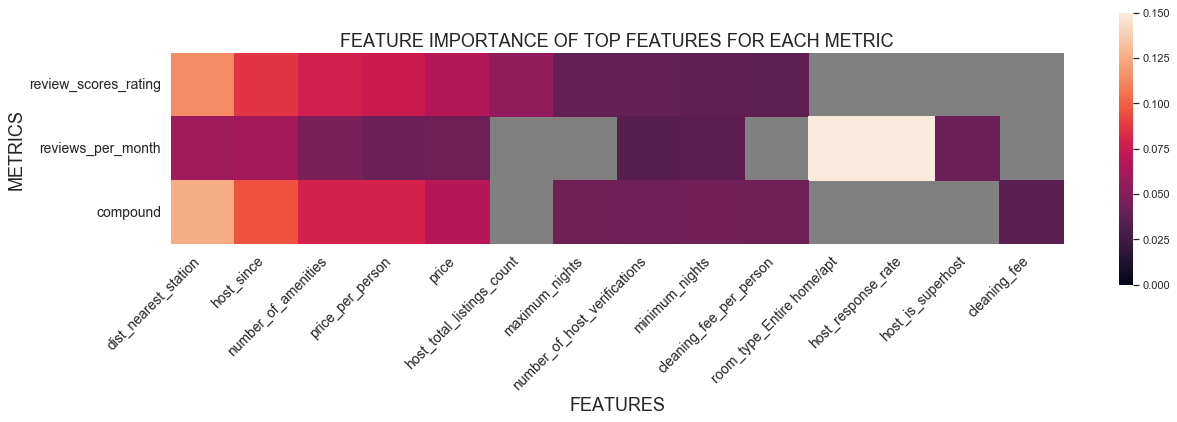

In [73]:
# heatmap

# transpose 'feat' dataFrame to have features on x-axis and metrics on y-axis
feat_ = feat.transpose()

# plot
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(feat_, mask = feat_== 0, vmin=0, vmax=0.15, square=True, cbar_kws={"shrink": .5}) #, center=0
ax.set_facecolor('grey')
ax.set_xticklabels(xlabels, rotation=45, horizontalalignment='right', fontsize = 14)
ax.set_yticklabels(ylabels, verticalalignment='center', fontsize = 14)  
plt.xlabel('FEATURES', fontsize = 18)
plt.ylabel('METRICS', fontsize = 18)
plt.title('FEATURE IMPORTANCE OF TOP FEATURES FOR EACH METRIC' , fontsize = 18)
plt.show()

*Comment: All values above 0.15 are plotted in the same shade. This was done to reduce the range for visualization purposes, as all values except one are in the range [0, 0.15].*

From this heatmap, we first notice that many of the top ten features are common for most metrics, and that `number_of_reviews` is the most important for all of them. As was previously stated, `reviews_per_month` was most likely obtained from `number_of_reviews`, which explains why the importance of this feature is as high for this metric.

The importance of the top features seems to decrease progressively, in a similar manner for all the metrics except for `reviews_per_month`. In fact, for the latter, features do not follow the same order of importance (`host_since` for instance). 

# MULTIPLE CITIES ANALYSIS

From now on, the same analysis can be launched for all the cities of the Airbnb dataset for which the transports dataset is available. This will allow to do some interesting comparisons and analyses.

### FIND CITIES COMMUN TO BOTH DATASETS

In [3]:
data_location_airbnb        = '../data/DataSet'
data_location_transports    = '../data/Transports'
#data_location_airbnb        = '../data/test_airbnb'
#data_location_transports    = '../data/test_transp'
output_location             = '../data/AllCitiesOutput'


# get cities from transport data set
all_transport_files = os.listdir(data_location_transports) 
transport_cities    = [file.split('_')[0] for file in all_transport_files]
# drop duplicates: each city has 3 files therefore is present 3 times in the transport_cities list
transport_cities    = list(set(transport_cities))
tmp_transports      = transport_cities
transport_cities    = [x.replace('-',' ') for x in transport_cities]
transport_cities    = [x.lower() for x in transport_cities]

# get cities from airbnb data set
all_airbnb_files    = os.listdir(data_location_airbnb) 
airbnb_cities       = [file.split('_')[1] for file in all_airbnb_files]
# drop duplicates: each city has several files therefore is present 3 times in the transport_cities list
airbnb_cities       = list(set(airbnb_cities))
tmp_airbnb          = airbnb_cities
airbnb_cities       = [x.replace('-',' ') for x in airbnb_cities]
airbnb_cities       = [x.lower() for x in airbnb_cities] #remove capital letters
airbnb_cities       = [city.replace(' city', '') for city in airbnb_cities]

# get common cities
common_cities       = list(set(transport_cities).intersection(set(airbnb_cities)))

# get the indexs of the common cities in both datasets
indices_transports  = [transport_cities.index(x) for x in common_cities]
indices_airbnb      = [airbnb_cities.index(x) for x in common_cities]

# get the original names of the common cities in the 2 datasets (not formatted)
common_transport_cities = [tmp_transports[i] for i in indices_transports]
common_airbnb_cities    = [tmp_airbnb[i] for i in indices_airbnb]

# print common cities in a pretty table
print('The common cities are:\n')
# nice print
nb_per_row = 5
t = PrettyTable(['Common cities', 'Common cities (cont.)', 'Common cities (cont..)', 'Common cities (cont...)', 'Common cities (cont....)'])
for i in range(0, int(np.ceil(len(common_cities)/nb_per_row))):
    if len(common_cities[2*i:nb_per_row*i+nb_per_row]) == nb_per_row:
        t.add_row(common_cities[nb_per_row*i:nb_per_row*i+nb_per_row])
    else:
        new_row = common_cities[nb_per_row*i:nb_per_row*i+nb_per_row]
        new_row = new_row + ['-']*(nb_per_row-len(new_row))
        t.add_row(new_row)
print(t)

The common cities are:

+---------------+-----------------------+------------------------+-------------------------+--------------------------+
| Common cities | Common cities (cont.) | Common cities (cont..) | Common cities (cont...) | Common cities (cont....) |
+---------------+-----------------------+------------------------+-------------------------+--------------------------+
|   barcelona   |       amsterdam       |        valencia        |        stockholm        |        manchester        |
|     vienna    |         lisbon        |         madrid         |          london         |      rio de janeiro      |
|    montreal   |         sydney        |        brussels        |        hong kong        |          milan           |
|     naples    |       melbourne       |        beijing         |          venice         |         istanbul         |
|   edinburgh   |         boston        |         tokyo          |          paris          |          ottawa          |
|    seattle    

In [4]:
#################################################################
#################### get list of files names ####################
#################################################################


# filter only common cities use for loop to maintain order (common_airbnb_cities and common_transport_cities have the 
# same order)
all_files_airbnb            = os.listdir(data_location_airbnb)
all_files_airbnb_common     = []
for j in common_airbnb_cities:
    all_files_airbnb_common = np.append(all_files_airbnb_common, [i for i in all_files_airbnb if ('_'+j+'_') in i])
files_listings              = [i for i in all_files_airbnb_common if 'listings_detailed.csv' in i]
files_comments              = [i for i in all_files_airbnb_common if '_reviews.csv' in i]

all_files_transports        = os.listdir(data_location_transports)
all_files_transports_common = []
for j in common_transport_cities:
    all_files_transports_common = np.append(all_files_transports_common, [i for i in all_files_transports if (j+'_') in i])
files_transports            = [i for i in all_files_transports_common if '_stations.geojson' in i]

save_list('common_listings_files',   '.', files_listings)
save_list('common_comments_files',   '.', files_comments)
save_list('common_transports_files', '.', files_transports)

In [10]:
data_location_airbnb        = '../data/DataSet'
data_location_transports    = '../data/Transports'
output_location             = '../data/AllCitiesOutput'

files_listings   = read_list('common_listings_files.txt', '.')
files_comments   = read_list('common_comments_files.txt', '.')
files_transports = read_list('common_transports_files.txt', '.')

# GIACOMO:

files_listings   = files_listings[0:10]
files_comments   = files_comments[0:10]
files_transports = files_transports[0:10]

# LAURINE:
'''
files_listings   = files_listings[10:20]
files_comments   = files_comments[10:20]
files_transports = files_transports[10:20]
'''

# PAULINE:
'''
files_listings   = tmp[20:30]
files_comments   = files_comments[20:30]
files_transports = files_transports[20:30]
'''

# SIRINE:
'''
files_listings   = tmp[30:]
files_comments   = files_comments[30:]
files_transports = files_transports[30:]
'''

'\nfiles_listings   = tmp[30:]\nfiles_comments   = files_comments[30:]\nfiles_transports = files_transports[30:]\n'

In [ ]:
#################################################################
################### run the complete analysis ###################
#################################################################
idx_advancement = 0
random_seed = 1
for listing_file, comment_file, transport_file in zip(files_listings, files_comments, files_transports):
    city_name            = listing_file.split('_')[1]
    
    try:
        df_listings_detailed = pd.read_csv(data_location_airbnb + '/' + listing_file, low_memory = False)
        df_comments          = pd.read_csv(data_location_airbnb + '/' + comment_file, low_memory = False)

        print('%.0f/%.0f : Running complete analysis for city %s ...'%(idx_advancement, len(files_listings), city_name))

        # check that the 3 files are for the same city:
        #print(listing_file)
        #print(comment_file)
        #print(transport_file)

        idx_advancement += 1

        with HiddenPrints():
            # sentiment analysis
            _, _, comments_sentiments_en = analyze_comments(df_comments) 
            comments_sentiments_en.to_csv(output_location + '/' + city_name + '_df_sentiment.csv')
            comments_sentiments_en.drop(columns = ['neutrality', 'positivity', 'negativity'], inplace = True)

        # add distance to stations
        df_station           = geojson_to_dataframe(data_location_transports + '/' + transport_file)    
        stations_coord       = get_station_coord(df_station)
        listings_coord       = get_listing_coord(df_listings_detailed)
        min_distances        = dist_to_nearest_station_haversine(stations_coord, listings_coord)
        df_listings_detailed['dist_nearest_station'] = min_distances

        with HiddenPrints():
            # data cleaning
            df_success_metrics = buildSuccessMetricsDf(df_listings_detailed, comments_sentiments_en)
            df_cleaned         = cleanAndMergeData(df_listings_detailed, df_success_metrics, use_neigh = True)

            # random forest analysis, single target
            df_importance_simple = pd.DataFrame()
            df_error_simple      = pd.DataFrame()
            for metric in df_success_metrics.columns.tolist():
                df_importance, df_error, rf_model = perform_rf_simple(df_cleaned, df_success_metrics, metric, 
                                                                     random_seed = random_seed, tune = False,
                                                                     plot_res = [False, False, False, False],
                                                                     saveFig = [True, True, True, False], 
                                                                     save_tag = city_name + '_single_' + metric + '_', 
                                                                     save_destination = output_location)
                df_importance['metric']           = [metric]*df_importance.shape[0]
                df_error['metric']                = [metric]*df_error.shape[0]
                df_importance_simple              = pd.concat([df_importance_simple, df_importance], sort = True)
                df_error_simple                   = pd.concat([df_error_simple, df_error], sort = True)

            # standardize data
            f = FeaturesTools(df_cleaned, df_success_metrics.columns.tolist(), random_seed = random_seed)
            df_cleaned_standardized = f.preprocess_features(preprocessing_type = 'standardize_robust')
            # random forest analysis, multi target
            f = FeaturesTools(df_cleaned_standardized, df_success_metrics.columns.tolist(), random_seed = random_seed)
            df_importance_multi, df_error_multi, rf_model_multi = f.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False, 
                                                                                        saveFigures = [True, True, True, False],
                                                                                        saveTag = city_name + '_multiple_metrics_', 
                                                                                        saveLocation = output_location)

            # save results
            df_cleaned.to_csv(output_location + '/' + city_name + '_df_input_cleaned.csv')
            df_station.to_csv(output_location + '/' + city_name + '_stations.csv')
            df_importance_simple.to_csv(output_location + '/' + city_name + '_df_importance_simple.csv')
            df_error_simple.to_csv(output_location + '/' + city_name + '_df_error_simple.csv')
            df_importance_multi.to_csv(output_location + '/' + city_name + '_df_importance_multi.csv')
            df_error_multi.to_csv(output_location + '/' + city_name + '_df_error_multi.csv')
    except:
        print('An error occurred for city %s. Continue with next city'%(city_name))
        continue


##  RESULTS COMPARISON 
Now that results for all cities within the list are available, results can be compared.

In [3]:
output_location = '../data/final_all_cities_outputs'
all_cities_results = os.listdir(output_location) 

performance_files_simple = [i for i in all_cities_results if 'error_simple.csv' in i]
performance_files_multi  = [i for i in all_cities_results if 'error_multi.csv' in i]
importance_files_simple  = [i for i in all_cities_results if 'importance_simple.csv' in i]
importance_files_multi   = [i for i in all_cities_results if 'importance_multi.csv' in i]
cleaned_city_listings    = [i for i in all_cities_results if 'input_cleaned.csv' in i]
#cities                   = [file.split('_')[0] for file in all_transport_files]

# simple check that all the files are present:
print('The number of each .csv file is:')
print('%.0f\t%.0f\t%.0f\t%.0f\t%.0f\n'%(len(performance_files_simple), len(performance_files_multi),
                                        len(importance_files_simple), len(importance_files_multi), 
                                        len(cleaned_city_listings)))

The number of each .csv file is:
34	34	34	34	34



## GENERATION OF SANKEY PLOTS FOR EVERY CITIES 

Sankey plots are generated for all the cities, to compare the importance of the single-target RF model features for all the cities.
A treshold of 0.01 on the features importance is used to only display the most important features.

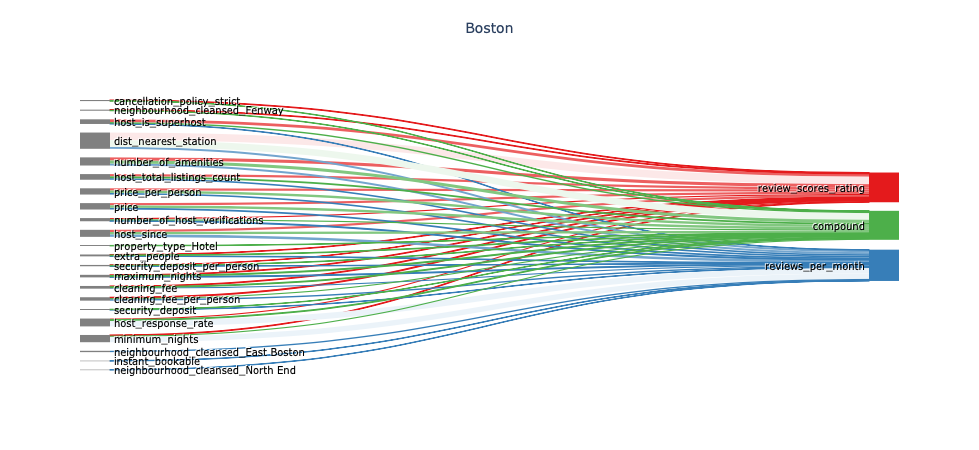

In [4]:
import importlib
import feature_tools
importlib.reload(feature_tools)

success_metrics         = ['review_scores_rating', 'reviews_per_month', 'compound']
fig_saving_folder       = '../data/all_cities_analysis'
column_weights_name     = 'feature_importance'
column_features_name    = 'feature'
treshold_importance     = 0.01

f = feature_tools.FeaturesTools()
for city_imp_file in importance_files_simple:
    city_name      = city_imp_file.split('_')[0]
    print('Creating sankey plot for city %s.............'%(city_name), end = '\r')
    with HiddenPrints():
        df_imp_city    = pd.read_csv(output_location + '/' + city_imp_file)
        list_of_imp_df = []
        for metric in success_metrics:
            list_of_imp_df += [df_imp_city.loc[df_imp_city.metric == metric]]

        df_sankey = build_sankey_input_df(list_of_imp_df, success_metrics, column_weights_name, 
                                      column_features_name, weight_treshold = treshold_importance)
        f.interactive_sankey(df_sankey, figureTitle = city_name, savingDestination = fig_saving_folder, 
                            saveTag = city_name + '_sankey_plot_treshold=' + str(treshold_importance), 
                            showFigure = False)



## COMPARISON BY IMPORTANCE SIMILARITY
To compare the cities, a dimple approach is selected. The goal is to determine the degree of similarity between cities based on the most important features determining the success of an Airbnb. A good ranking statistic having the following properties has to be selected:
- handle non-conjointness (different elements in 2 compared lists)
- weight high ranks more heavily than lower ranks (higher ranks are more important!)
The best measure combining all those criteria is the so-called *Rank-biased overlap (RBO)*.

The original paper describing this technique is the following:

*Webber, W., Moffat, A., & Zobel, J. (2010). A similarity measure for indefinite rankings. ACM Transactions on Information Systems (TOIS), 28(4), 20.*

The authors provide good explanations and comparisons of/with the other standard ranking comparison statistical tools. A good summary is provided by the following blog:

https://ragrawal.wordpress.com/2013/01/18/comparing-ranked-list/

The python RBO implementation of the blog's author is used here (Source: https://github.com/ragrawal/measures).

The similarity measure is computed between all the cities and an heatmap illustration is provided. The plot_heat_map and create_save_interactive_heatmap functions defined in main_functions provide the matplotlib plot (to be shown in the notebook) and a pyplot html interactive figure (only saved, to be shown in the data-story).

Clustering is performed with an euclidean distance measure with the same principle used to create dendrograms. The clusters are then extracted from the re-ordered matrix of similarities using a matematical morphology. The matrix is treated as an image and each cluster is a 4-connected (pixels) object.

To visualize the results, interactive heatmap and bubble plots are created and saved in .html format. Those graphs are not shown here because of their size but are present in our data story.

## COMPARISON OF RESULTS FROM SINGLE-LABEL RANDOM FOREST

With the code below, heatmaps are generated for the three metrics. The aim is to show similarity in terms of features importance for each metric and for each city. This showed that cities could be clustered based on these similarities.

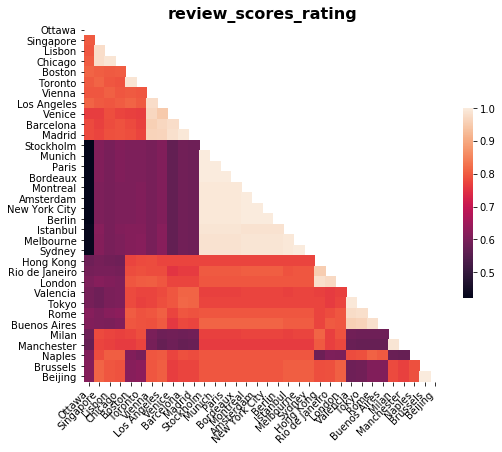

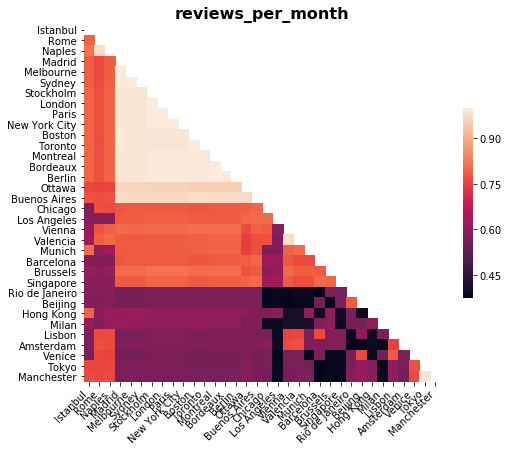

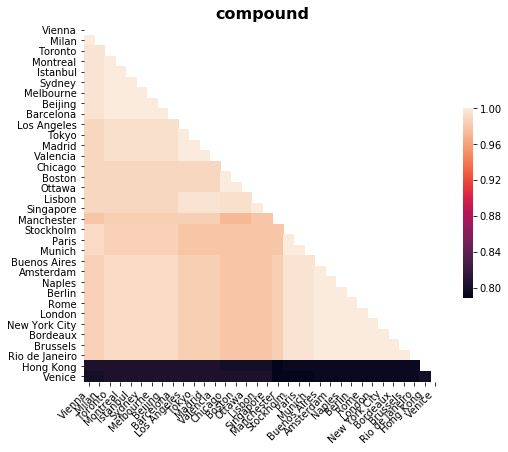

In [11]:
import importlib
import main_functions
importlib.reload(main_functions)

fig_saving_folder       = '../data/all_cities_analysis'
city_images_location    = '../data/cities_pictures'

all_images_files        = os.listdir(city_images_location) 
# number of features to compare: the first n_comp are selected for each city
n_comp                  = 5
success_metrics         = ['review_scores_rating', 'reviews_per_month', 'compound']
treshold_binarization   = [0.9, 0.9, 1]
min_elements_by_cluster = 2
vertical_padding        = 350
horizontal_padding      = 100
text_size               = 250
text_font               = 'Arial' 

# create df and compute similarities
imp_df_simple         = main_functions.get_merged_df_impotances(importance_files_simple, output_location)
df_of_scores, metrics = main_functions.pairwise_similarity_clustered(imp_df_simple, n_comp, success_metrics)

# create and save figures    
for df_similarities, metric, treshold in zip(df_of_scores, metrics, treshold_binarization):
    save_tag_static      = metric + '_features_importances_ranking_similarity'
    save_tag_interactive = metric + '_importances_ranking_similarity_interactive'
    polar_plot_save_tag  = metric + '_importance_clusters_polar_plot'
    bubble_plot_save_tag = metric + '_importance_clusters_bubble_plot'

    
    # create, save and show static pdf heatmaps
    main_functions.plot_heat_map(df_similarities, fig_saving_folder, metric, save_tag_static, use_diagonal_mask = True)
    # create and save interactive html heatmaps
    main_functions.create_save_interactive_heatmap(df_similarities, fig_saving_folder, save_tag_interactive)
    
    # preview of matrix binarization to identify clusters
    # main_functions.matrix_treshold_binarization_preview(df_similarities, treshold)
    # get clusters
    clustered_elements = main_functions.extract_clusters_from_diag_blocks(df_similarities, treshold, min_elements_by_cluster)
    
    '''
    print('For metric %s'%(metric))
    print(clustered_elements)
    print('------')
    '''
    
    # create radial plot and save it
    main_functions.create_save_radial_plot(clustered_elements, importance_files_simple, 
                                           'importance_simple.csv', output_location, 
                                           fig_saving_folder, n_comp, 
                                           polar_plot_save_tag, metric = metric)
    
    # create bubble plot and save it
    main_functions.create_save_bubble_plot(clustered_elements, importance_files_simple, 
                                           'importance_simple.csv', output_location, 
                                           fig_saving_folder, n_comp, 
                                           bubble_plot_save_tag, metric = metric, showFigure = False)
    
    # from the custers dict, generate row-concatenated images that show all the cities in each cluster
    main_functions.cities_clusters_to_images_rows(clustered_elements, all_images_files, 
                                                  city_images_location, horizontal_padding, 
                                                  vertical_padding, text_size, text_font, 
                                                  '../data/clustered_cities_jpg', metric, show_result_img = False)


The heatmaps for both the metric `review_scores_ratings` and `reviews_per_month` show clear defined clusters. Indeed we observe patches of similar colors meaning groups of cities with similar reviews. However, for the `compound` metric, results appear to be very similar between every cities, even though there might be some groups that share higher similarities than others. Overall the compound results are pretty internationally valid.

## COMPARISON OF RESULTS FROM MULTI-LABEL RANDOM FOREST

Now that we saw that not all cities had the same feature importance classification but rather that groups of cities, it is time to regroup them according to feature importance in terms of the success metric. That is, the following heatmap shows clusters of cities according to the results of the multi-label random forest.

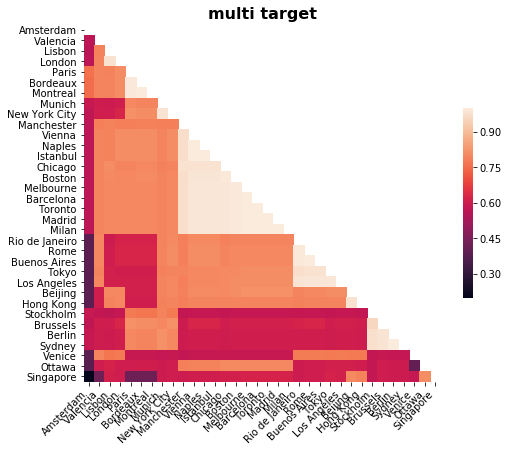

"\nprint('For metric %s'%('multiple'))\nprint(clustered_elements)\nprint('------')\n"

In [12]:
import importlib
import main_functions
importlib.reload(main_functions)


fig_saving_folder       = '../data/all_cities_analysis'
city_images_location    = '../data/cities_pictures'
all_images_files        = os.listdir(city_images_location) 
treshold_binarization   = 0.94
min_elements_by_cluster = 2
n_comp                  = 5
vertical_padding        = 350
horizontal_padding      = 100
text_size               = 250
text_font               = 'Arial' 

# create df and compute similarities
imp_df_multi          = main_functions.get_merged_df_impotances(importance_files_multi, output_location)
df_of_scores, metrics = main_functions.pairwise_similarity_clustered(imp_df_multi, n_comp, success_metrics_list = 'multi')

# create and save figures    
heatmap_save_tag_static      = 'multi_target_features_importances_ranking_similarity'
heatmap_save_tag_interactive = 'multi_target_importances_ranking_similarity_interactive'
polar_plot_save_tag          = 'multi_target_importance_clusters_polar_plot'
bubble_plot_save_tag         = 'multi_target_importance_clusters_bubble_plot'

# create, save and show static pdf heatmaps
main_functions.plot_heat_map(df_of_scores[0], fig_saving_folder, 'multi target', heatmap_save_tag_static, 
                             use_diagonal_mask = True)
# create and save interactive html heatmaps
main_functions.create_save_interactive_heatmap(df_of_scores[0], fig_saving_folder, heatmap_save_tag_interactive)

# preview of matrix binarization to identify clusters
# main_functions.matrix_treshold_binarization_preview(df_of_scores[0], treshold_binarization)
# get clusters
clustered_elements = main_functions.extract_clusters_from_diag_blocks(df_of_scores[0], treshold_binarization, min_elements_by_cluster)

# create radial plot and save it
main_functions.create_save_radial_plot(clustered_elements, importance_files_multi, 
                                       'importance_multi.csv', output_location, 
                                       fig_saving_folder, n_comp, polar_plot_save_tag, 
                                       metric = 'multi')

# create bubble plot and save it
main_functions.create_save_bubble_plot(clustered_elements, importance_files_multi, 
                                       'importance_multi.csv', output_location, 
                                       fig_saving_folder, n_comp, 
                                       bubble_plot_save_tag, metric = 'multi', showFigure = False)

# from the custers dict, generate row-concatenated images that show all the cities in each cluster
main_functions.cities_clusters_to_images_rows(clustered_elements, all_images_files, 
                                              city_images_location, horizontal_padding, 
                                              vertical_padding, text_size, text_font, 
                                              '../data/clustered_cities_jpg', 'multi', show_result_img = False)

'''
print('For metric %s'%('multiple'))
print(clustered_elements)
print('------')
'''

As expected, several pairs of cities get similar multi-label random forest results. Cities can thus be grouped according to such similarites since they share results. This is done using image processing techniques, more precisely: morphological analysis.